#اتصال گوگل **درایو**

In [2]:
#اتصال گوگل درایو
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/code_Thesis/python_code/Test_code/code/
!ls

Mounted at /content/drive
/content/drive/MyDrive/code_Thesis/python_code/Test_code/code
analyzeData.ipynb  dtr.ipynb		       mlp.ipynb	   test2.ipynb
ckpt		   generateHistoricData.ipynb  model_base.ipynb
constants.ipynb    generateTestFeatures.ipynb  param_models.ipynb
data		   mergeData.ipynb	       predToFile.ipynb


# **تعریف متغیرها**

In [3]:
import os

# taghir mikonad
#_______________________________________________________________________________
state ='A'# can test for state B or C
#_______________________________________________________________________________



if not os.path.exists('../submit/'):
    os.mkdir('../submit/')
    
# Test A online
if state == 'A':
    DATA_PATH_TEST = '../data/testA/'  # file name format: record_2019-01-02.csv
    DATE_TEST = '2019-01-25'
    YESTERDAY_TEST = 'testA_record_2019-01-24.csv'
    SUBMIT_FILE = 'testA_submit_2019-01-25.csv'
    SUBMIT_RESULT = '../submit/testA/3_testA_results.csv'
    DECAY = 0.98  # with_tol: 1->12.28 no_tol: 1->12.05 0.98->11.88 0.95->12.12
    if not os.path.exists('../submit/testA/'):
        os.mkdir('../submit/testA/')
#__________________________________________________________________________________
DATA_PATH_ORI = '../data/train/'  # file name format: record_2019-01-01.csv
DATA_PATH_FEAT = DATA_PATH_ORI + 'features/' #بعد آنالیز 
if not os.path.exists(DATA_PATH_FEAT):
    os.mkdir(DATA_PATH_FEAT)
#__________________________________________________________________________________
DATA_PATH_RESULT = DATA_PATH_ORI+'results/'
if not os.path.exists(DATA_PATH_RESULT):
    os.mkdir(DATA_PATH_RESULT)
#___________________________________________________________________________________
DATA_PATH_MODELS = DATA_PATH_ORI+'models/'
if not os.path.exists(DATA_PATH_MODELS):
    os.mkdir(DATA_PATH_MODELS)
#___________________________________________________________________________________
DATA_PATH_PRED = '../data/preds/'
if not os.path.exists(DATA_PATH_PRED):
    os.mkdir(DATA_PATH_PRED)
#___________________________________________________________________________________
DATA_PATH_SUBMIT = '../data/submit/'
if not os.path.exists(DATA_PATH_SUBMIT):
    os.mkdir(DATA_PATH_SUBMIT)
#___________________________________________________________________________________
#بررسی شود
DATA_PATH_IMG = DATA_PATH_ORI+'images/'
if not os.path.exists(DATA_PATH_IMG):
    os.mkdir(DATA_PATH_IMG)
#__________________________________________________________________________________
EPOCH_EXCEED = 20
#__________________________________________________________________________________
DATE_START = '2019-01-01'
DAYS = 23
NUM_STATIONS = 81
NUM_LINES = 3
NUM_TYPES = 4
NUM_TIME_BLOCK = 24 * 6
SIZE_TIME_BLOCK = 10
TIME_POS_START = 11  # yyyy-mm-dd HH:MM:SS
DATE_POS_END = 10  # yyyy-mm-dd HH:MM:SS
DATA_A_DAY = NUM_TIME_BLOCK * NUM_TYPES * 2 * NUM_STATIONS
STATUS_IN = 1
STATUS_OUT = 0

HEADER_ORI = ['time', 'lineID', 'stationID', 'deviceID', 'status', 'userID', 'payType']
HEADER_TIME = 'time'
HEADER_LINE_ID = 'lineID'  # A B C
HEADER_STATION_ID = 'stationID'
HEADER_DEVICE_ID = 'deviceID'
HEADER_STATUS = 'status'  # 0 out, 1 in
HEADER_USER_ID = 'userID'
HEADER_PAY_TYPE = 'payType'
HEADER_TIME_BLOCK = 'time_block'
HEADER_WEEK_DAY = 'weekDay'
HEADER_HOLIDAY = 'holiday'
HEADER_AVER_WEEK = 'averWeek'
HEADER_FLOW = 'flow'

FEAT_LEN = [144, 81, 2, 4, 7, 2, 1, 1, 1, 1]  # 244
# FEAT_LEN = [144, 81, 2, 4, 7, 1]
# 144 + 81 + 2 + 4 + 7 + 2 + 1 + 1 + 1 + 1

HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday', 'flow']
# the flow of yesterday ...., if not have, use average flow of all similar time
HEADER_HIS = ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn', 'yesterdayNormal']
# HEADER_HIS = ['yesterday']
HEADER_TEST = ['stationID', 'startTime', 'endTime', 'inNums', 'outNums']
HEADER_IN = 'inNums'
HEADER_OUT = 'outNums'

HOLIDAY = ['2019-01-01']

COLORS = ['r', 'g', 'm', 'k', 'c', 'b', 'y',
         'tab:grey', 'tab:gray', 'tab:purple', 'tab:pink', 'tab:orange', ]

TRAIN = 'train'
VALID = 'valid'
GRID = 'grid'
PRED = 'pred'


# features: station_id|range(0, 81), pay_type|range(0, 4), line_id|range(0, 3), in_out|range(0, 2),
#           mi_10|range(0, 6 * 24), week|range(0, 7), holiday|range(0, 2), average_same_week_day(in_out_pay_type),
#           average_pre_num(pre 1, 2, 3 day or a week)
# label: number_in or number_out
# use or not: user_id, devices_id

WEEK_DAY_DICT = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}



# **آنالیز ومرج داده ها**

In [4]:
import os
import datetime
import pandas
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import traceback
import argparse

#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
#PRED = 'PRED'
#VALID = 'VALID'

mode = TRAIN
#_______________________________________________________________________________
def generateXTicks(x):
    ticks = []
    for minu in x:
        hour = str(int(np.floor(minu / 60))).zfill(2)
        minutes = str(int(minu % 60)).zfill(2)
        tick = '%s:%s' % (hour, minutes)
        ticks.append(tick)
    return ticks

#_______________________________________________________________________________
def setTicker(sub_fig, fontsize):
    x = np.arange(0, NUM_TIME_BLOCK, 10).tolist()
    sub_fig.set_xticks(x)

    sub_fig.tick_params(axis='both', width=2, length=10, pad=10)

    for tick in sub_fig.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in sub_fig.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

#_______________________________________________________________________________
def drawStationInOut(num_in, num_out, img_name):
    print('drawing %s ......' % img_name)
    fig = plt.figure(figsize=(20, 18))
    sub_fig = fig.add_subplot(111)

    x = np.arange(0, NUM_TIME_BLOCK*10, 10)
    ticks = generateXTicks(x)
    sub_fig.plot(ticks, num_in, c=COLORS[0], label='flow_in')
    sub_fig.plot(ticks, num_out, c=COLORS[1], label='flow_out')
    plt.legend(loc='upper right', fontsize=20)
    plt.title(img_name[:-4], fontsize=20)
    plt.grid(axis='x')

    setTicker(sub_fig, 20)

    plt.savefig(DATA_PATH_IMG + img_name)
    plt.close('all')
#_______________________________________________________________________________
#فایل های اکسل موجود در آدرس را برمیگرداند
def getFilesList(path):
    dir_list = os.listdir(path)
    files_list = []
    for name in dir_list:
        if name[-4:] == '.csv':
            files_list.append(name)
    return sorted(files_list)

#برای مشخص کردن روز هفته.تاریخ میگیرد و عدد روز را پس میدهد
def getWeekDay(date_str):
    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    return date.weekday()


def timeToMinutes(time):
    # transfer hh:MM:SS to the amount of minutes in a day
    strings = time.split(':')
    minutes = 60 * int(strings[0]) + int(strings[1])
    return minutes

#  آرایه ای از تاریخ و زمان را میگیرد وآرایه ای 144 تایی از بلاک هاای 10 دقیقه ای را تشکیل میدهد و برای هر زمان بلاک مورد نظر را افزایش میدهد 
def toTimeBlock(data_time):
    #NUM_TIME_BLOCK = 24 * 6
    num_flow = np.zeros(NUM_TIME_BLOCK)#آرایه با  طول 144 و مقدارهای صفر

    for time in data_time:
        #TIME_POS_START = 11  # yyyy-mm-dd HH:MM:SS برای قسمت زمان
        minutes = timeToMinutes(time[TIME_POS_START:])
        #SIZE_TIME_BLOCK = 10 # time interval
        block = int(np.floor(minutes / SIZE_TIME_BLOCK))
        num_flow[block] = num_flow[block] + 1

    return num_flow
 

#تکمیل
def analyze(path, day=0 , modee=TRAIN):
    mode = modee
    try:

        if mode == TRAIN:
            #print(DATA_PATH_FEAT + 'features_'+DATE_START+'.csv')
            #if os.path.exists(DATA_PATH_FEAT + 'features_'+DATE_START+'.csv'):
                #print('Training features exist')
                #return
            files_list = getFilesList(path)

            # output = open(DATA_PATH_FEAT + 'features.csv', 'w')
            # output.write(','.join(HEADER_FEAT) + '\n')
        else:
            #DATA_PATH_TEST = '../data/testA/'  # file name format: testA_record_2019-01-28.csv
            print(DATA_PATH_TEST + 'features_yesterday.csv') 
            if os.path.exists(DATA_PATH_TEST + 'features_yesterday.csv'):
                print('Test features exist:'+DATA_PATH_TEST + 'features_yesterday.csv')
                return
            #YESTERDAY_TEST = 'testA_record_2019-01-28.csv'
            files_list = [YESTERDAY_TEST]

            # output = open(path + 'features_yesterday.csv', 'w')
            # output.write(','.join(HEADER_FEAT) + '\n')

        feats = {}#<class 'dict'>
        #HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday', 'flow']
        for header in HEADER_FEAT:
            feats[header] = []
            #{'block': [], 'stationID': [], 'status': [], 'payType': [], 'weekDay': [], 'holiday': [], 'flow': []}
        # print(files_list)

        for file_name in [files_list[day]]:
            date_x = file_name[7:-4] 
            #DATA_PATH_ORI = '../data/train/'  # file name format: record_2019-01-01.csv
            #DATA_PATH_FEAT = DATA_PATH_ORI + 'features/'
            if os.path.exists(DATA_PATH_FEAT + 'features_'+date_x+'.csv'):
                print('Training features exist:'+DATA_PATH_FEAT + 'features_'+date_x+'.csv')
                return
            print('reading %s ......' % file_name)
            
            data = pandas.read_csv(path+file_name)
            #HEADER_STATION_ID = 'stationID'
            data_station = data[HEADER_STATION_ID].values#8آرایه  از اعداد ایستگاها بین 0 و1
            #HEADER_STATUS = 'status'   0 out, 1 in
            data_status = data[HEADER_STATUS].values
            ind_out_in = []#<class 'list'>کلاسی متشکل از دو آرایه که یکی برای ورود و یکی برای خروجه
            #STATUS_IN = 1 
            #STATUS_OUT = 0
            ind_out_in.append(data_status == STATUS_OUT)
            ind_out_in.append(data_status == STATUS_IN)
            #HEADER_PAY_TYPE = 'payType'
            data_pay_type = data[HEADER_PAY_TYPE].values
            ind_type = []#<class 'list'>کلاسی متشکل از چهار آرایه  که هر کدام مربوط به یک ایستگاه است
            #NUM_TYPES = 4
            for t in range(NUM_TYPES):
                ind_type.append(data_pay_type == t)
            #HEADER_TIME = 'time'
            data_time = data[HEADER_TIME].values
            # data_line_id = data[HEADER_LINE_ID].values
            #DATE_POS_END = 10  # yyyy-mm-dd HH:MM:SS
            date = data_time[0][:DATE_POS_END]#فقط تاریخ بدون اسم اضافه
            week_day = getWeekDay(date)#روز هفته به عدد
            holiday = 0
            #HOLIDAY = ['2019-01-01']
            if date in HOLIDAY:
                holiday = 1

            #NUM_TIME_BLOCK = 24 * 6
            flow_out_in_one_day = np.zeros((2, NUM_TIME_BLOCK))#دو تا آرایه 144 تایی 
            #NUM_STATIONS = 81
            for station_id in range(NUM_STATIONS):
                #ind_station=  آرایه ای از ترو و فالس ها [ True  True  True ... False False False]
                #data_station =8آرایه  از اعداد ایستگاها بین 0 و1
                ind_station = data_station == station_id#خروجی فالس و ترو 
                print('station %d, flow: %d' % (station_id, sum(ind_station)))# جمع عبارت هار ترو در آرایه یعنی تعداد افرادی که از این ایستگاه استفاده کرده اند
                flow_out_in = np.zeros((2, NUM_TIME_BLOCK))#دو تا آرایه صفر 144 تایی

                print('generating features station %d......' % station_id)
                #ind_out_in = []#<class 'list'>کلاسی متشکل از دو آرایه که یکی برای ورود و یکی برای خروجه
                #len(ind_out_in)=2
                #برای ورود و خروج
                for i in range(len(ind_out_in)):#یکبار برای ورود یکبار خروج ا
                    #i=0 خروج  i=1 ورود
                    #ind_station=آرایه ای از فالس وتروها که نشان دهنده ی استفاده از ایستگاه هستن
                    ind_s_o = ind_station & ind_out_in[i]
                    ##NUM_TYPES = 4
                    for t in range(NUM_TYPES):
                        ind_s_o_t = ind_s_o & ind_type[t]#هم از ایستگاه مورد نظر هم ورود یا خروج و هم نوع پرداخت مورد نظر
                         
                        #data_time = data[HEADER_TIME].values #HEADER_TIME = 'time'
                        data_time_ind = data_time[ind_s_o_t]#زمان مرتبط با موارد بالا 
                        # data_line_id_ind = data_line_id[ind_s_o_t]

                        flow_time_block = toTimeBlock(data_time_ind)#مشخص کردن بلام مورد نظر مرتبط با تایم
                        # flow_time_block = toTimeBlockFast(data_time_ind)
                        # برای رسم نمودار روزانه برای هر ایستگاه و کل روز
                        flow_out_in[i] = flow_out_in[i] + flow_time_block
                        flow_out_in_one_day[i] = flow_out_in_one_day[i] + flow_time_block

                        # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday']
                        # for b in range(len(flow_time_block)):
                        #     output.write(str(b) + ',' + str(station_id) + ',' + str(i) + ',' + str(t) + ',' +
                        #                  str(week_day) + ','+str(holiday) + ',' + str(flow_time_block[b])+'\n')

                        feats[HEADER_FEAT[0]].extend(np.arange(NUM_TIME_BLOCK))#144
                        feats[HEADER_FEAT[1]].extend(np.ones((NUM_TIME_BLOCK), dtype=np.int) * station_id)# station_id in range(NUM_STATIONS)
                        feats[HEADER_FEAT[2]].extend(np.ones((NUM_TIME_BLOCK), dtype=np.int) * i)# i in range(len(ind_out_in))
                        feats[HEADER_FEAT[3]].extend(np.ones((NUM_TIME_BLOCK), dtype=np.int) * t)# t in range(NUM_TYPES)
                        feats[HEADER_FEAT[4]].extend(np.ones((NUM_TIME_BLOCK), dtype=np.int) * week_day)#شماره روز هفنه 
                        feats[HEADER_FEAT[5]].extend(np.ones((NUM_TIME_BLOCK), dtype=np.int) * holiday)#اگر جزو روز تعطیل  باشد مقدار یک میگیرد
                        feats[HEADER_FEAT[6]].extend(flow_time_block.tolist())#جریان در بلاک مورد نظر


                #img_name = '%s_%d_in_out_%s.png' % (file_name[:-4], station_id, WEEK_DAY_DICT[week_day])
                #drawStationInOut(flow_out_in[1], flow_out_in[0], img_name)
                  # break

        #img_name = '%s_all_in_out_%s.png' % (file_name[:-4], WEEK_DAY_DICT[week_day])
        #drawStationInOut(flow_out_in_one_day[1], flow_out_in_one_day[0], img_name)
          # break

        feats = pandas.DataFrame(feats)
        if mode == TRAIN:
            feats.to_csv((DATA_PATH_FEAT + 'features_%s.csv') % date, index=False)
        elif mode == PRED:
            feats.to_csv(DATA_PATH_TEST + 'features_yesterday.csv', index=False)
    except Exception as err:
        print(traceback.print_exc())
if __name__ == '__main__':
  processes = 23
  #DAYS = 23
  pool = multiprocessing.Pool(processes=processes)
  for i in range(DAYS):
    #DATA_PATH_ORI = '../data/train/'  # file name format: record_2019-01-01.csv
    pool.apply_async(analyze, (DATA_PATH_ORI, i,TRAIN))
  pool.close()
  pool.join()
  #DATA_PATH_TEST = '../data/testA/'  # file name format: testA_record_2019-01-28.csv
  analyze(DATA_PATH_TEST,day=0,modee=PRED)

Training features exist:../data/train/features/features_2019-01-01.csv
Training features exist:../data/train/features/features_2019-01-07.csv
Training features exist:../data/train/features/features_2019-01-06.csv
Training features exist:../data/train/features/features_2019-01-03.csv
Training features exist:../data/train/features/features_2019-01-23.csv
Training features exist:../data/train/features/features_2019-01-18.csv
Training features exist:../data/train/features/features_2019-01-08.csv
Training features exist:../data/train/features/features_2019-01-14.csv
Training features exist:../data/train/features/features_2019-01-09.csv
Training features exist:../data/train/features/features_2019-01-05.csv
Training features exist:../data/train/features/features_2019-01-12.csv
Training features exist:../data/train/features/features_2019-01-21.csv
Training features exist:../data/train/features/features_2019-01-16.csv
Training features exist:../data/train/features/features_2019-01-04.csv
Traini

In [ ]:
import pandas


#تکمیل
def mergeData():
    #DAYS = 25
    #DATE_START = '2019-01-01'
    #DATA_PATH_ORI = '../data/train/'  # file name format: record_2019-01-01.csv
    #DATA_PATH_FEAT = DATA_PATH_ORI + 'features/' #بعد آنالیز 
    #HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday', 'flow']
    feats = {}
    for header in HEADER_FEAT:
        feats[header] = []
    for d in range(DAYS):
        date = DATE_START[:-2] + str(d+1).zfill(2)
        #print(date)
        data = pandas.read_csv((DATA_PATH_FEAT + 'features_%s.csv') % date)
        print((DATA_PATH_FEAT + 'features_%s.csv') % date)#چاپ اسم فایل هلی در حال اتصال
        for header in HEADER_FEAT:
            feats[header].extend(data[header].values.tolist())
        print('number of block:',len(feats['block']))#چاپ تعداد سطرها در هر مرحله 
        #print(len(feats['stationID']))
        #print(len(feats['status']))
        #print(len(feats['payType']))
        #print(len(feats['weekDay']))
        #print(len(feats['holiday']))
        #print(len(feats['flow']))

    feats = pandas.DataFrame(feats)
    #print('bad az dadaframe')
    #print(len(feats['block']))
    #print(len(feats['stationID']))
    #print(len(feats['status']))
    #print(len(feats['payType']))
    #print(len(feats['weekDay']))
    #print(len(feats['holiday']))
    #print(len(feats['flow']))
    feats.to_csv((DATA_PATH_FEAT + 'features.csv'), index=False)
    #print('shape file excel',feats.shape)
    data_excel = pandas.read_csv(DATA_PATH_FEAT +'features.csv')
    print('shape file excel (features.csv)',data_excel.shape)


if __name__ == '__main__':
    mergeData()


In [5]:
#Import required libraries 
import keras #library for neural network
import pandas as pd #loading data in table form  
import seaborn as sns #visualisation 
import matplotlib.pyplot as plt #visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import normalize #machine learning algorithm library
data = '../data/train/features/features.csv'
input_file = pd.read_csv(data)
#input_file=input_file[0:1000]
print("Info of the data1:",input_file.info())
print("Describing the data1: ",input_file.describe())
input_file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146176 entries, 0 to 2146175
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   block      int64  
 1   stationID  int64  
 2   status     int64  
 3   payType    int64  
 4   weekDay    int64  
 5   holiday    int64  
 6   flow       float64
dtypes: float64(1), int64(6)
memory usage: 114.6 MB
Info of the data1: None
Describing the data1:                block     stationID  ...       holiday          flow
count  2.146176e+06  2.146176e+06  ...  2.146176e+06  2.146176e+06
mean   7.150000e+01  4.000000e+01  ...  4.347826e-02  2.494841e+01
std    4.156823e+01  2.338091e+01  ...  2.039312e-01  4.998947e+01
min    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00
25%    3.575000e+01  2.000000e+01  ...  0.000000e+00  0.000000e+00
50%    7.150000e+01  4.000000e+01  ...  0.000000e+00  9.000000e+00
75%    1.072500e+02  6.000000e+01  ...  0.000000e+00  2.900000e+01
max    1.430000e+02  8.000000e+01  ..

,block,stationID,status,payType,weekDay,holiday,flow
0,0,0,0,0,1,1,0.0
1,1,0,0,0,1,1,0.0
2,2,0,0,0,1,1,0.0
3,3,0,0,0,1,1,0.0
4,4,0,0,0,1,1,0.0
...,...,...,...,...,...,...,...
2146171,139,80,1,3,2,0,0.0
2146172,140,80,1,3,2,0,0.0
2146173,141,80,1,3,2,0,0.0
2146174,142,80,1,3,2,0,0.0


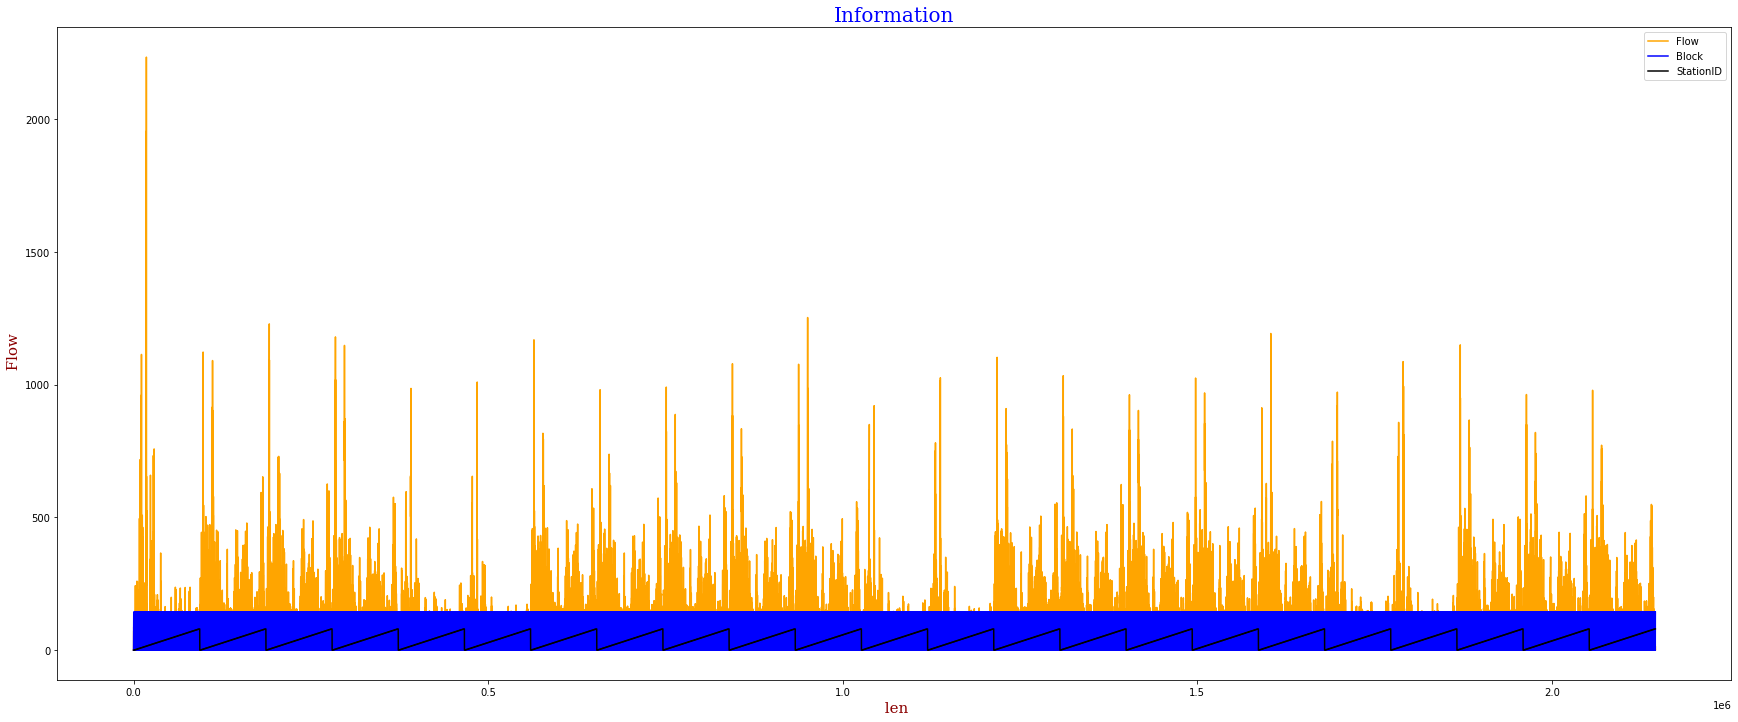

In [6]:
import numpy
from matplotlib import pyplot

input_file_shape=input_file[:]#برای یک روز 
plt.figure(figsize=(30,12))


pyplot.plot(input_file_shape['flow'], label='Flow',color='orange')
pyplot.plot(input_file_shape['block'], label='Block',color='blue')
pyplot.plot(input_file_shape['stationID'], label='StationID',color='black')

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.xlabel(" len", fontdict = font2)
plt.ylabel(" Flow", fontdict = font2)
plt.title("Information", fontdict = font1)
plt.legend()
pyplot.show()

# **create features_his for Train & Test**

In [ ]:
import pandas as pd
import numpy as np

#_______________________________________________________________________________
# the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
#DATA_A_DAY = NUM_TIME_BLOCK * NUM_TYPES * 2 * NUM_STATIONS
data_a_day = DATA_A_DAY
LOG_NAME = 'genHisData'
yesterday_type = 1  # 0 normal, 1 Saturday then use last Saturday as input, Monday then use last Friday as input
#_______________________________________________________________________________

# !!! python actions are performed along line
def genFlowYesterdayNormal(dataFLow, holidays, weekdays):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    size = len(dataFLow)#تعداد 2.332.800 روز
    days = int(size/data_a_day)#تعداد 25 روز
    dataFLow = np.reshape(dataFLow, (days, data_a_day))#ستون جریان را به 25 روز که 25 آرایه 93312 تایی تبدیل میکند مجموعا 25 آرایه 
    #flow_gen = با مقادیر صفر dataFLow مشابه
    flow_gen = np.zeros(dataFLow.shape)#به همان شکل جریان 25 تا آرایه بامقادیر صفر میسازیم

    for i in range(0, days):
        # if first day, use the average of all days
        idx_holiday = holidays == holidays[i]

        # first day, use mean val of all weekdays
        if (i < 1) or (holidays[i] != holidays[i-1]):
            idx_weekday = weekdays % 7 <= 4
            idx = idx_holiday & idx_weekday
            flow_gen[i, :] = np.mean(dataFLow[idx, :], axis=0)
        else:
            flow_gen[i, :] = dataFLow[i-1, :]

    return np.reshape(flow_gen, (size))

def genFlowYesterday(dataFLow, holidays, weekdays):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    size = len(dataFLow)#تعداد 2.332.800 روز
    days = int(size/data_a_day)#تعداد 25 روز
    dataFLow = np.reshape(dataFLow, (days, data_a_day))#ستون جریان را به 25 روز که 25 آرایه 93312 تایی تبدیل میکند مجموعا 25 آرایه 
    #flow_gen = با مقادیر صفر dataFLow مشابه 
    flow_gen = np.zeros(dataFLow.shape)#به همان شکل جریان 25 تا آرایه بامقادیر صفر میسازیم
 
    # using yesterday's data
    # construct as historical feature by using yesterday's data
    for i in range(0, days):
        # if first day, use the average of all days
        #روزهای هالیدی را ترو کن در آرایه
        idx_holiday = holidays == holidays[i]# آرایه 25 تایی شامل ترو و فالس 

        wd = weekdays[i]
        # Saturday then use last Saturday as input, if no last Saturday, use mean val of all weekends
        if wd % 7 == 5: #if 5: 'Saturday'ااگر روز شنبه بود
            #for i=4,11,18
            if i - 7 < 0:#هفته اول باشد 
                #for i=4
                idx_weekday = weekdays % 7 > 4#  را در آرایه هفته ترو کنSundayو Saturday روزهای  wekend روزهای تعطیل
                idx = idx_holiday & idx_weekday
                flow_gen[i, :] = np.mean(dataFLow[idx, :], axis=0)
            else:
                flow_gen[i, :] = dataFLow[i - 7, :]
        # Monday then use last Friday as input, if no last Friday, use mean val of all weekdays
        elif wd % 7 == 0:#if 0: 'monday'ااگر روز دوشنبه بود
            #for i=6,13,20
            if i - 3 < 0:#
                #for i=noting
                idx_weekday = weekdays % 7 <= 4#  را در آرایه هفته ترو کن  weekday روزهای کاری
                idx = idx_holiday & idx_weekday
                flow_gen[i, :] = np.mean(dataFLow[idx, :], axis=0)
            else:
                flow_gen[i, :] = dataFLow[i - 3, :]
        # first day, use mean val of all weekdays
        elif (i < 1):
            idx_weekday = weekdays % 7 <= 4#ترو کردن روزهای کاری در آرایه weekday
            idx = idx_holiday & idx_weekday#ترو کردن روزهای کاری هفته بجز ویکند و هالیدی
            flow_gen[i, :] = np.mean(dataFLow[idx, :], axis=0)
        else:
            flow_gen[i, :] = dataFLow[i-1, :]

    return np.reshape(flow_gen, (size))


def genFlowLastWeek(dataFLow, holidays):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    size = len(dataFLow)#تعداد 2.332.800 روز
    days = int(size/data_a_day)#همان 25 روز
    dataFLow = np.reshape(dataFLow, (days, data_a_day))
    flow_gen = np.zeros(dataFLow.shape)

    # construct as historical feature by using last weeks' data
    for i in range(0, days):
        # if first week, use the average of all same weekdays
        if (i < 7) or (holidays[i] != holidays[i-7]):
            idx_holiday = holidays == holidays[i]
            weekdays = np.array([False] * days)#آرایه کلا فالس
            weekdays[np.arange(i % 7, days, 7)] = True#جاهایی که روز مرتیط در هر هفته ترو میشود
            weekdays = weekdays & idx_holiday
            flow_gen[i, :] = np.mean(dataFLow[weekdays, :], axis=0)
        else:
            flow_gen[i, :] = dataFLow[i-7, :]

    return np.reshape(flow_gen, (size))


def genFlowAverWeek(dataFLow, holidays):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    size = len(dataFLow)
    days = int(size/data_a_day)
    dataFLow = np.reshape(dataFLow, (days, data_a_day))
    flow_gen = np.zeros(dataFLow.shape)

    # construct as historical feature by using pass weeks' data
    for i in range(0, days):
        # if first week, use the average of all same weekdays

        idx_holidays = holidays == holidays[i]

        weekdays = np.array([False] * days)

        # only use average of before same weekdays
        weekdays[np.arange(i % 7, i, 7)] = True

        # use the average of all same weekdays
        # weekdays[np.arange(i % 7, days, 7)] = True

        weekdays = weekdays & idx_holidays

        if sum(weekdays) < 1:
            weekdays[np.arange(i % 7, days, 7)] = True
            weekdays = weekdays & idx_holidays

        # print(weekdays)

        flow_gen[i, :] = np.mean(dataFLow[weekdays, :], axis=0)

    return np.reshape(flow_gen, (size))


def genFlowAverWeekOutIn(dataFLow, holidays):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    # ignore type
    size = len(dataFLow)
    days = int(size/data_a_day)
    dataFLow = np.reshape(dataFLow, (days, data_a_day))
    temp_gen = np.zeros(dataFLow.shape)
    flow_gen = np.zeros(dataFLow.shape)

    step = NUM_TIME_BLOCK * NUM_TYPES
    # get the in out flow ignore type
    for i in range(days-1, -1, -1):
        for s in range(0, data_a_day, step):
            temp = np.reshape(dataFLow[i, s: s+step], (NUM_TYPES, NUM_TIME_BLOCK))
            temp_gen[i, s: s+step] = np.tile(np.sum(temp, axis=0), (NUM_TYPES))

    # construct as historical feature by using pass weeks' data
    for i in range(0, days):
        # if first week, use the average of all same weekdays
        idx_holidays = holidays == holidays[i]

        weekdays = np.array([False] * days)
        weekdays[np.arange(i % 7, i, 7)] = True

        weekdays = weekdays & idx_holidays

        if sum(weekdays) < 1:
            weekdays[np.arange(i % 7, days, 7)] = True
            weekdays = weekdays & idx_holidays

        # print(weekdays)

        flow_gen[i, :] = np.mean(temp_gen[weekdays, :], axis=0)

    return np.reshape(flow_gen, (size))

#ستون تعطیلات را میگرد و یک آرایه 25 تایی از اعداد تعطیلات را بر میگرداند
def getHolidays(holidays):
    size = len(holidays)
    # data_a_day= is 144(block) * 4(type)* 2(in_out) * 81(station)
    days = int(size / data_a_day)#همان 25 روز
      #[1 1 1 ... 0 0 0]کل روز ها
      # [[1 1 1 ... 1 1 1]#روز اول 
      #  [0 0 0 ... 0 0 0]
      #  [0 0 0 ... 0 0 0]
      #          ...
      #  [0 0 0 ... 0 0 0]
      #  [0 0 0 ... 0 0 0]
      #  [0 0 0 ... 0 0 0]]روز 25

    holidays = np.reshape(holidays, (days, data_a_day))
    holidays = holidays[:, 0]#تبدیل همه به یک آرایه 25 تایی که هر درایه نشان دهنده یک روز است
    #[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]برای هالیدی
    #[1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4]برای ویکند
    return holidays


def genHisData():
    #LOG_NAME = 'genHisData'
    print(LOG_NAME + ': reading data ......')
    #DATA_PATH_FEAT = '../data/train/features/'
    data_features = pd.read_csv(DATA_PATH_FEAT+'features.csv')
    #HEADER_HOLIDAY = 'holiday'
    #HEADER_WEEK_DAY = 'weekDay'
    holidays = getHolidays(data_features[HEADER_HOLIDAY].values)
    weekdays = getHolidays(data_features[HEADER_WEEK_DAY].values)

    #HEADER_FLOW = 'flow'
    print(LOG_NAME + ': genFlowYesterday ......')
    flow_yesterday = genFlowYesterday(data_features[HEADER_FLOW].values, holidays, weekdays)

    #HEADER_FLOW = 'flow'
    print(LOG_NAME + ': genFlowYesterdayNormal ......')
    flow_yesterday_normal = genFlowYesterdayNormal(data_features[HEADER_FLOW].values, holidays, weekdays)


    print(LOG_NAME + ': genFlowLastWeek ......')
    flow_last_week = genFlowLastWeek(data_features[HEADER_FLOW].values, holidays)

    print(LOG_NAME + ': genFlowAverWeek ......')
    flow_aver_week = genFlowAverWeek(data_features[HEADER_FLOW].values, holidays)

    print(LOG_NAME + ': genFlowAverWeekOut ......')
    flow_aver_week_out_in = genFlowAverWeekOutIn(data_features[HEADER_FLOW].values, holidays)  # ignore type

    # we need to forecast in out flow, so it may be no use to ignore in_out

    # print(LOG_NAME + ': genFlowAverWeekALL ......')
    # flow_aver_week_all = genFlowAverWeekALL(data_features[HEADER_FLOW].values)  # ignore time block

    # print(LOG_NAME + ': genFlowAverWeekType ......')
    # flow_aver_week_all = genFlowAverWeekType1(data_features[HEADER_FLOW].values)  # ignore in_out
    # flow_aver_week_all = genFlowAverWeekType2(data_features[HEADER_FLOW].values)  # ignore in_out
    # flow_aver_week_all = genFlowAverWeekType3(data_features[HEADER_FLOW].values)  # ignore in_out
    # flow_aver_week_all = genFlowAverWeekType4(data_features[HEADER_FLOW].values)  # ignore in_out
    #
    # flow_aver_week_all = genFlowAverWeekBlock(data_features[HEADER_FLOW].values)  # ignore in_out and type
    #
    # flow_aver_week_all = genFlowAverWeekBlock(data_features[HEADER_FLOW].values)  # ignore in_out and type and time block
    #
    # flow_aver_week_all = genFlowAverWeekBlock(data_features[HEADER_FLOW].values)  # ignore station

    print(LOG_NAME + ': save file ......')
    data_features[HEADER_HIS[0]] = flow_yesterday
    data_features[HEADER_HIS[1]] = flow_last_week
    data_features[HEADER_HIS[2]] = flow_aver_week
    data_features[HEADER_HIS[3]] = flow_aver_week_out_in
    data_features[HEADER_HIS[4]] = flow_yesterday_normal

    data_features.to_csv(DATA_PATH_FEAT+'features_his.csv', index=False)


if __name__ == '__main__':
    genHisData()



genHisData: reading data ......
genHisData: genFlowYesterday ......
genHisData: genFlowYesterdayNormal ......
genHisData: genFlowLastWeek ......
genHisData: genFlowAverWeek ......
genHisData: genFlowAverWeekOut ......
genHisData: save file ......


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

# the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
data_a_day = DATA_A_DAY
LOG_NAME = 'genTestFeatures'

# !!! python actions are performed along line
mode = PRED

def generateXTicks(x):
    ticks = []
    for minu in x:
        hour = str(int(np.floor(minu / 60))).zfill(2)
        minutes = str(int(minu % 60)).zfill(2)
        tick = '%s:%s' % (hour, minutes)
        ticks.append(tick)
    return ticks


def genFlowAverWeekOutIn(dataFLow):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    # ignore type
    days = dataFLow.shape[0]
    temp_gen = np.zeros(dataFLow.shape)

    step = NUM_TIME_BLOCK * NUM_TYPES
    # get the in out flow ignore type
    for i in range(days-1, -1, -1):
        for s in range(0, data_a_day, step):
            temp = np.reshape(dataFLow[i, s: s+step], (NUM_TYPES, NUM_TIME_BLOCK))
            temp_gen[i, s: s+step] = np.tile(np.sum(temp, axis=0), (NUM_TYPES))

    # construct as historical feature by using pass weeks' data
    flow_gen = np.mean(temp_gen, axis=0)

    return flow_gen


def genHisData():


    print(LOG_NAME + ': reading data ......')
    data_features = pd.read_csv(DATA_PATH_FEAT+'features.csv')
    data_yesterday = pd.read_csv(DATA_PATH_TEST+'features_yesterday.csv')

    feats = {}

    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday'
    print(LOG_NAME + 'generating basic features ......')
    feats[HEADER_FEAT[0]] = data_yesterday[HEADER_FEAT[0]].values
    feats[HEADER_FEAT[1]] = data_yesterday[HEADER_FEAT[1]].values
    feats[HEADER_FEAT[2]] = data_yesterday[HEADER_FEAT[2]].values
    feats[HEADER_FEAT[3]] = data_yesterday[HEADER_FEAT[3]].values
    week_day = getWeekDay(DATE_TEST)
    feats[HEADER_FEAT[4]] = np.ones((DATA_A_DAY)) * week_day
    holiday = 0
    if DATA_PATH_TEST in HOLIDAY:
        holiday = 1
    feats[HEADER_FEAT[5]] = np.ones((DATA_A_DAY)) * holiday

    if mode == VALID:
        feats[HEADER_FEAT[6]] = data_yesterday[HEADER_FEAT[6]].values

    data_week_day = data_features[HEADER_WEEK_DAY].values
    idx_week_day = data_week_day == week_day

    data_holiday = data_features[HEADER_HOLIDAY].values
    idx_holidays = data_holiday == holiday

    idx = idx_week_day & idx_holidays

    flow_week_day = data_features[HEADER_FLOW].values[idx]
    size = len(flow_week_day)
    days = int(size/data_a_day)
    flow_week_day = np.reshape(flow_week_day, (days, data_a_day))



    print(LOG_NAME + ': genFlowYesterday ......')
    feats[HEADER_HIS[0]] = data_yesterday[HEADER_FLOW].values
    print(LOG_NAME + ': genFlowLastWeek ......')
    feats[HEADER_HIS[1]] = flow_week_day[-1, :]
    print(LOG_NAME + ': genFlowAverWeek ......')
    feats[HEADER_HIS[2]] = np.mean(flow_week_day, axis=0)

    print(LOG_NAME + ': genFlowAverWeekOut ......')
    feats[HEADER_HIS[3]] = genFlowAverWeekOutIn(flow_week_day)  # ignore type

    print(LOG_NAME + ': genFlowYesterdayNormal ......')
    feats[HEADER_HIS[4]] = data_yesterday[HEADER_FLOW].values

    df = pd.DataFrame(feats)
    if mode == PRED:
        df.to_csv(DATA_PATH_TEST+'features_his.csv', index=False)
    elif mode == VALID:
        df.to_csv(DATA_PATH_TEST + 'features_valid.csv', index=False)


if __name__ == '__main__':
    genHisData()



genTestFeatures: reading data ......
genTestFeaturesgenerating basic features ......
genTestFeatures: genFlowYesterday ......
genTestFeatures: genFlowLastWeek ......
genTestFeatures: genFlowAverWeek ......
genTestFeatures: genFlowAverWeekOut ......
genTestFeatures: genFlowYesterdayNormal ......


# **Real & Test data**

In [ ]:
import pandas as pd
import numpy as np

data_tt = pd.read_csv(DATA_PATH_FEAT + 'features_2019-01-25.csv')
data_tt=data_tt['flow'].values
data_tt = np.reshape(data_tt, (-1, 1))
size = len(data_tt)
days = int(size/93312)
data_tt = np.reshape(data_tt, (days, 93312))
temp_genn = np.zeros((days, 144 * 2 * 81))
stepp = 144 * 4#576
for i in range(days-1, -1, -1):#اندازه تعداد روز از انتها به ابتدا
        for s in range(0, 93312, stepp):
            tempp = np.reshape(data_tt[i, s: s+stepp], (4, 144))
            temp_genn[i, int(s/4): int((s+stepp)/4)] = np.sum(tempp, axis=0)
a=np.reshape(temp_genn, (days * 144 * 2 * 81))#23.328
in_t = np.zeros((144 * 81))
out_t = np.zeros((144 * 81))
for i in range(0, len(a), 144 * 2):
    # print(int(i/2)+NUM_TIME_BLOCK)
    out_t[int(i/2): int(i/2)+144] = a[i: i+144]
    in_t[int(i/2): int(i/2)+144] = a[i+144: i+144*2]
submit = pd.read_csv(DATA_PATH_TEST + SUBMIT_FILE)
submit['input_real'] = in_t
submit['output_real'] = out_t
pathh_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
submit.to_csv(pathh_save, index=False)

# **model Base**

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas

def listToArray(data_list):
    data = data_list[0]
    if data.ndim < 2:
        data = np.reshape(data, (-1, 1))
    for d in data_list[1:]:
        if d.ndim < 2:
            d = np.reshape(d, (-1, 1))
        data = np.hstack([data, d])
    return data


def flowIgnoreType(dataFLow):
    # the number of data a day is 144(block) * 4(type)* 2(in_out) * 81(station)
    # ignore type
    size = len(dataFLow)
    days = int(size/DATA_A_DAY)
    #print(dataFLow.shape)
    dataFLow = np.reshape(dataFLow, (days, DATA_A_DAY))
    #print(dataFLow.shape)
    #جداسازی بر حسب چهار نوع تایپ
    temp_gen = np.zeros((days, NUM_TIME_BLOCK * 2 * NUM_STATIONS))

    step = NUM_TIME_BLOCK * NUM_TYPES#576
    # get the in out flow ignore type
    for i in range(days-1, -1, -1):#اندازه تعداد روز از انتها به ابتدا
        for s in range(0, DATA_A_DAY, step):
            temp = np.reshape(dataFLow[i, s: s+step], (NUM_TYPES, NUM_TIME_BLOCK))
            temp_gen[i, int(s/NUM_TYPES): int((s+step)/NUM_TYPES)] = np.sum(temp, axis=0)

    return np.reshape(temp_gen, (days * NUM_TIME_BLOCK * 2 * NUM_STATIONS))#23.328


def readTrainData(input_file):
    #input_file = '../data/train/features/features_his.csv'
    data = pandas.read_csv(input_file)
    # HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday', 'flow']
    # HEADER_HIS = ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn', 'yesterdayNormal']
    data_y = data[HEADER_FEAT[-1]].values#ستون فلو
    max_label = np.max(data_y)#2234 ماکزیمم عدد ستون فلو 
    train_y = data_y #2332800

    train_x = np.zeros((len(data_y), sum(FEAT_LEN)), dtype=np.float32)# ماتریس صفر 239*2.322.800 
    encoder = OneHotEncoder()

    v = 0
    for feat in HEADER_FEAT[:-1]:#بجز فلو
        data_feat = encoder.fit_transform(np.reshape(data[feat].values, (-1, 1)))
        data_feat = data_feat.toarray()
        # data_feat = data_feat
        train_x[:, sum(FEAT_LEN[:v]):sum(FEAT_LEN[:v+1])] = data_feat
        v += 1
    for feat in HEADER_HIS:
        data_feat = np.reshape(data[feat].values, (-1, 1))
        train_x[:, sum(FEAT_LEN[:v]):sum(FEAT_LEN[:v + 1])] = data_feat
        v += 1

    # train_x = listToArray(train_x)

    # train_x = pandas.DataFrame(train_x)

    return train_x, train_y

def readTrainPartial(input_file):
    data = pandas.read_csv(input_file)
    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday', 'flow']
    # ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn']
    days_left = [2,3,7,8,9,10,14,15,16,17,21,22,23,24]

    data_y = data[HEADER_FEAT[-1]].values
    train_y = np.reshape(data_y, (DAYS, DATA_A_DAY))
    train_y = train_y[days_left, :]
    train_y = train_y.flatten()

    train_x = np.zeros((len(train_y), sum(FEAT_LEN)), dtype=np.float32)
    encoder = OneHotEncoder()

    v = 0
    for feat in HEADER_FEAT[:-1]:
        data_feat = data[feat].values
        data_feat = np.reshape(data_feat, (DAYS, DATA_A_DAY))
        data_feat = data_feat[days_left, :]
        data_feat = data_feat.flatten()

        data_feat = encoder.fit_transform(np.reshape(data_feat, (-1, 1)))
        data_feat = data_feat.toarray()
        # data_feat = data_feat
        train_x[:, sum(FEAT_LEN[:v]):sum(FEAT_LEN[:v+1])] = data_feat
        v += 1
    for feat in HEADER_HIS:
        data_feat = data[feat].values
        data_feat = np.reshape(data_feat, (DAYS, DATA_A_DAY))
        data_feat = data_feat[days_left, :]
        data_feat = data_feat.flatten()

        data_feat = np.reshape(data_feat, (-1, 1))
        train_x[:, sum(FEAT_LEN[:v]):sum(FEAT_LEN[:v + 1])] = data_feat
        v += 1

    # train_x = listToArray(train_x)

    # train_x = pandas.DataFrame(train_x)

    return train_x, train_y


def dataForTree(input_file):
    data = pandas.read_csv(input_file)
    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday', 'flow']
    # ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn']

    data_y = data[HEADER_FEAT[-1]].values
    max_label = np.max(data_y)
    train_y = data_y

    train_x = []

    for feat in HEADER_FEAT[:-1]:
        data_feat = data[feat].values
        # data_feat = data_feat
        train_x.append(data_feat)
        print(data_feat.shape)
    for feat in HEADER_HIS:
        data_feat = data[feat].values
        train_x.append(data_feat)
        print(data_feat.shape)

    train_x = listToArray(train_x)

    # train_x = pandas.DataFrame(train_x)


    # train_x, train_y = dataIgnoreType(train_x, train_y)

    return train_x, train_y


def dataIgnoreType(x, y):
    y = flowIgnoreType(y)
    n_samples, n_feats = x.shape
    print(x.shape)
    x_new = np.zeros((int(n_samples/NUM_TYPES), n_feats))
    print(x_new.shape)
    yes_new = flowIgnoreType(x[:, 6])
    last_new = flowIgnoreType(x[:, 7])
    for i in range(0, n_samples, NUM_TIME_BLOCK * NUM_TYPES):
        x_new[int(i/ NUM_TYPES):int(i/ NUM_TYPES)+NUM_TIME_BLOCK, :] = x[i:i+NUM_TIME_BLOCK, :]
    x_new[:, 6] = yes_new
    x_new[:, 7] = last_new

    return x_new[:, [0,1,2,3,4,5,6,7,9]], y



def dataTransform(data):
    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday', 'flow']
    # ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn']

    data_y = data[HEADER_FEAT[-1]].values
    train_y = data_y

    train_x = []
    encoder = OneHotEncoder()

    for feat in HEADER_FEAT[:-1]:
        data_feat = encoder.fit_transform(np.reshape(data[feat].values, (-1, 1)))#ماتریس وان هات
        data_feat = data_feat.toarray()
        # data_feat = data_feat
        train_x.append(data_feat)
    for feat in HEADER_HIS:
        data_feat = data[feat].values
        train_x.append(data_feat)

    train_x = listToArray(train_x)

    # train_x = pandas.DataFrame(train_x)

    return train_x, train_y

#متناسب سازی شیپ ورودی برحسب خروجی
def shapeBatch(x, r):
    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday', 'flow']
    # ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn']
    m, n = x.shape #m=satrha ,n =sotonha همون قایل وان هات شده
    if n < sum(FEAT_LEN):#239
        data_feat = np.zeros((m, sum(FEAT_LEN)), dtype=np.float32)
        for i in range(m):
            for j in range(n-len(HEADER_HIS)):
                data_feat[i, int(sum(FEAT_LEN[j-1:j])+x[i, j])] = 1
                # print(int(sum(FEAT_LEN[:j])+x[i, j]))
        data_feat[:, -len(HEADER_HIS):] = x[:, -len(HEADER_HIS):]
    else:
        data_feat = np.array(x, dtype=np.float32)

    m, n = data_feat.shape
    data_feat = np.reshape(data_feat, (int(m/r), n * r))
    # print(np.max(data_feat))
    return data_feat

#فایل رو بگیر و لیست وان هات شده رو تحویل بده
def readTestData(test_file):
    data = pandas.read_csv(test_file)
    #HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday', 'flow']
    
    pred_x = []#list of array
    encoder = OneHotEncoder()
    for feat in HEADER_FEAT[:4]:#['block', 'stationID', 'status', 'payType']
        data_feat = encoder.fit_transform(np.reshape(data[feat].values, (-1, 1)))#برای هر ستون
        data_feat = data_feat.toarray()
        pred_x.append(data_feat)
    #HEADER_WEEK_DAY = 'weekDay'
    if HEADER_WEEK_DAY in HEADER_FEAT:#روزهای هفته
        data_feat = np.zeros((7), dtype=np.int)#برای مشخص کردن روز هفته
        #مقدار اندیس طبق روز هفته رو برابر یک کن.بقیه صفر(وان هات روزهای هفته) 
        data_feat[int(data[HEADER_WEEK_DAY].values[0])] = 1
        # print(data_feat)
        #numpy.tile(A, reps)Construct an array by repeating A the number of times given by reps.
        #از آرایه وان هات هفته به تعداد 93312 بار تکرار کن
        pred_x.append(np.tile(np.reshape(data_feat, (1, -1)), (DATA_A_DAY, 1)))
    #HEADER_HOLIDAY = 'holiday'
    if HEADER_HOLIDAY in HEADER_FEAT:#تعطیلات رسمی
        data_feat = np.zeros((2), dtype=np.int)
        data_feat[int(data[HEADER_HOLIDAY].values[0])] = 1
        pred_x.append(np.tile(np.reshape(data_feat, (1, -1)), (DATA_A_DAY, 1)))
    #HEADER_HIS = ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn', 'yesterdayNormal']
    for feat in HEADER_HIS:
        data_feat = data[feat].values
        pred_x.append(data_feat)

    pred_x = listToArray(pred_x)

    return pred_x


def readTestDataForTree(test_file):
    data = pandas.read_csv(test_file)
    # ['block', 'stationID', 'status', 'payType', 'weekDay', 'holiday']
    # ['yesterday', 'lastWeek', 'averWeek', 'averWeekOutIn']

    pred_x = []

    for feat in HEADER_FEAT[:-1]:
        data_feat = data[feat].values
        pred_x.append(data_feat)


    for feat in HEADER_HIS:
        data_feat = data[feat].values
        pred_x.append(data_feat)

    pred_x = listToArray(pred_x)

    return pred_x

# **Model 1**

In [8]:
import tensorflow as tf
import datetime
import time
import os
from tensorflow.python.keras.layers import Flatten, Dense, InputLayer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as KTF
from tensorflow.python.ops import math_ops
import random
import sklearn
import math
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import tensorflow
tensorflow.random.set_seed(1)
#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
PRED = 'PRED'
#VALID = 'VALID'
mode = TRAIN
training_epochs = 10
#_______________________________________________________________________________
#DATA_PATH_FEAT = '../data/train/features/'
input_file = DATA_PATH_FEAT + 'features_his.csv'
#DATA_PATH_TEST = '../data/testA/'
test_file = DATA_PATH_TEST + 'features_his.csv'
#DATA_PATH_MODELS ='../data/train/models/'
file_name ='../data/train/models/model_1.h5'
#training_epochs = 2000
batch_size = 144 * 4 * 2 * 81
shuffle_batch = False
shuffle_samples = False
FEAT_LEN = [144, 81, 2, 4]
HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'flow']
HEADER_HIS = []
n_inputs = sum(FEAT_LEN)#231
n_outputs = 3
n_mlp = [100, 100, 100]
# Read database
if mode == TRAIN:
    input_x, input_y = readTrainData(input_file)
    #input_x=ماتریس لن فایل در لن فیچرزلن با درایه های وان هات شده بجز ستون های مربوط به فلو(فلو دیروزیا هفته پیش)
    #input_y=مقادیر ستون فلو
    train_x = input_x[:-2*DATA_A_DAY, :]#ستون های دو روز ابتدایی و دو روز اتنهایی را در نظر نگیر
    train_y = input_y[:-2*DATA_A_DAY]
    n_samples = len(train_y)

    valid_x = np.reshape(input_x[-2*DATA_A_DAY:, :], (int(2*DATA_A_DAY / n_outputs), sum(FEAT_LEN) * n_outputs))#(62208*717)دو روز آخر
    valid_y = np.reshape(input_y[-2*DATA_A_DAY:], (int(2*DATA_A_DAY / n_outputs), n_outputs))#(62208*3)دو روز آخر

else:
    pred_x = readTestData(test_file)

files_r = os.listdir('../data/train/models')
for file in files_r:
  if file == file_name[21:]:
    os.remove(file_name)

mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_inputs * n_outputs,)))
for n in n_mlp:
    mlp.add(Dense(units=n, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Dense(units=n_outputs, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

def validate(mlp):
    pred_y = mlp.predict(valid_x)
    mae_ignore_type = np.mean(np.abs(flowIgnoreType(np.reshape(pred_y, (-1,1))) -
                                     flowIgnoreType(np.reshape(valid_y, (-1,1)))))
    return round(mae_ignore_type,2)

def writeToSubmit(preds):
    #print(preds.shape)
    preds = flowIgnoreType(preds)#حذب نوع پرداخت ها (ترکیب در جریان هایشان)
    #print(preds.shape)
    preds = preds * DECAY
    submit = pd.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
    in_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    out_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    for i in range(0, len(preds), NUM_TIME_BLOCK * 2):
        # print(int(i/2)+NUM_TIME_BLOCK)
        out_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i: i+NUM_TIME_BLOCK]
        in_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i+NUM_TIME_BLOCK: i+NUM_TIME_BLOCK*2]

    # less than 1 set to 0
    in_preds[in_preds < 1] = 0
    out_preds[out_preds < 1] = 0
    submit['input_model_1'] = in_preds
    submit['output_model_1'] = out_preds
    #now_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    path_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
    submit.to_csv(path_save, index=False)
    return path_save

def predict(mlp):
    pred_x = readTestData(test_file)
    input_x = shapeBatch(pred_x, n_outputs)
    y_pred = mlp.predict(input_x, verbose=1)
    #print(y_pred.shape)
    y_pred = np.reshape(y_pred, (-1, 1))
    #print(y_pred.shape)
    writeToSubmit((y_pred))

## Initialization
def generator(steps_per_epoch):
    while True:

        pos = np.arange(steps_per_epoch).tolist()#یک لیست از شماره صفر تا تعداد استپ هر اپوک
        if shuffle_batch:
            random.shuffle(pos)#بور بزن
        # print(pos)

        for i in pos:
            start = (i) * batch_size
            end = (i + 1) * batch_size
            if end > n_samples:
                end = n_samples
            batch_xs = shapeBatch(train_x[start:end, :], n_outputs)
            batch_ys = np.reshape(train_y[start:end], (int(batch_size / n_outputs), n_outputs))

            yield batch_xs, batch_ys

start = datetime.datetime.now()
optimizer = tf.keras.optimizers.Adam()
mlp.compile(
              loss='mean_squared_error',
              metrics=['accuracy'] )

if mode == TRAIN:

    steps_per_epoch = int(np.ceil(n_samples / batch_size))
    check_point = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch' )#period=1=save_freq=1

    tensor_board = TensorBoard(log_dir='logs/' + file_name[:-3] + '/', histogram_freq=0, write_graph=True,
                               write_images=False)
    result = mlp.fit(generator(steps_per_epoch), steps_per_epoch=steps_per_epoch,
                               epochs=training_epochs,shuffle=shuffle_samples,  validation_data=(valid_x, valid_y), callbacks=[check_point, tensor_board])

    print("*************************Finish the softmax output layer training*****************************")
    
    predict(mlp)
    mae_validate = validate(mlp)
    end = datetime.datetime.now()
    rcd = str(end) + '\n'
    rcd += "batch_size: " + str(batch_size) + '\n'
    rcd += "training_epochs: " + str(training_epochs) + '\n'
    rcd += "n_inputs: " + str(n_inputs) + '\n'
    rcd += "n_outputs: " + str(n_outputs) + '\n'
    rcd += "n_mlp: " + str(n_mlp) + '\n'
    rcd += "mae_validate: " + str(mae_validate) + '\n'
    #rcd += "time: " + str(end - start) + '\n'
    print(rcd)
    log_file = open(DATA_PATH_RESULT + "mlp_result.txt", "a")
    log_file.write(rcd)
    log_file.close()
    #mlp.save('ckpt/'+file_name[:-3]+'/'+file_name)

elif mode == PRED:

    mlp.load_weights(file_name)
    predict(mlp)

#_______________________________performance_____________________________________
EPSILON=0.000000001
def smape(act,forc):
    return (2*np.mean(np.abs(act - forc) / ((np.abs(act) + np.abs(forc)) + EPSILON))*100)
def mre(act,forc):
    return (np.mean(np.abs(act - forc) / ((np.abs(act)) + EPSILON))*100)
#_______________________________________________________________________________ 
data_p = pandas.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
#_______________________________input________________________________________________ 
#_______________________________input Flow________________________________________________
print('_______________________________input Flow________________________________________________ ') 
testt_input=data_p['input_real']
predictionss_input=data_p['input_model_1']
test_input = np.asarray(testt_input)
predictions_input = np.asarray(predictionss_input)
mae_input=round(mae(test_input, predictions_input),2)
print("mean absolute error(MAE)=",mae_input)
mse_input = sklearn.metrics.mean_squared_error(test_input, predictions_input)
rmse_input =round(math.sqrt(mse_input),2)
print("root mean squared error (RMSE)=",rmse_input)
smape_input=round(smape(test_input, predictions_input),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_input)
mre_input=round(mre(test_input, predictions_input),2)
if mre_input>10000 :
  mre_input=round((mre_input*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_input)
#_______________________________output Flow________________________________________________ 
print('_______________________________output Flow________________________________________________ ')
testt_output=data_p['output_real']
predictionss_output=data_p['output_model_1']
test_output = np.asarray(testt_output)
predictions_output = np.asarray(predictionss_output)
mae_output=round(mae(test_output, predictions_output),2)
print("mean absolute error(MAE)=",mae_output)
mse_output = sklearn.metrics.mean_squared_error(test_output, predictions_output)
rmse_output =round(math.sqrt(mse_output),2)
print("root mean squared error (RMSE)=",rmse_output)
smape_output=round(smape(test_output, predictions_output),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_output)
mre_output=round(mre(test_output, predictions_output),2)
if mre_output>10000 :
  mre_output=round((mre_output*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_output)

Epoch 1/10
21/21 [==============================] - 13s 589ms/step - loss: 2780.4243 - accuracy: 0.2496 - val_loss: 2251.2190 - val_accuracy: 0.2380
Epoch 2/10
21/21 [==============================] - 10s 472ms/step - loss: 1974.5540 - accuracy: 0.2402 - val_loss: 1606.7485 - val_accuracy: 0.2388
Epoch 3/10
21/21 [==============================] - 10s 494ms/step - loss: 1497.7971 - accuracy: 0.3437 - val_loss: 1208.4303 - val_accuracy: 0.4226
Epoch 4/10
21/21 [==============================] - 10s 473ms/step - loss: 1250.8444 - accuracy: 0.4654 - val_loss: 1033.5258 - val_accuracy: 0.4764
Epoch 5/10
21/21 [==============================] - 10s 469ms/step - loss: 1132.9957 - accuracy: 0.4895 - val_loss: 945.3477 - val_accuracy: 0.4504
Epoch 6/10
21/21 [==============================] - 10s 467ms/step - loss: 1058.6901 - accuracy: 0.2561 - val_loss: 889.8327 - val_accuracy: 0.2351
Epoch 7/10
21/21 [==============================] - 10s 472ms/step - loss: 1006.5210 - accuracy: 0.2382 - va

# **Model 2**

In [9]:
import tensorflow as tf
import datetime
import time
import os
from tensorflow.python.keras.layers import Flatten, Dense, InputLayer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as KTF
from tensorflow.python.ops import math_ops
import random
import sklearn
import math
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import tensorflow
tensorflow.random.set_seed(1)
#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
PRED = 'PRED'
#VALID = 'VALID'
mode = TRAIN
training_epochs = 10
#_______________________________________________________________________________
#DATA_PATH_FEAT = '../data/train/features/'
input_file = DATA_PATH_FEAT + 'features_his.csv'
#DATA_PATH_TEST = '../data/testA/'
test_file = DATA_PATH_TEST + 'features_his.csv'
#DATA_PATH_MODELS ='../data/train/models/'
file_name ='../data/train/models/model_2.h5'
#training_epochs = 2000
batch_size = 144 * 4 * 2 * 81
shuffle_batch = False
shuffle_samples = False
FEAT_LEN = [144, 81, 2, 4, 7]
HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay', 'flow']
HEADER_HIS = []
n_inputs = sum(FEAT_LEN)#238
n_outputs = 3
n_mlp = [100, 100, 100]
# Read database
if mode == TRAIN:
    input_x, input_y = readTrainData(input_file)
    #input_x=ماتریس لن فایل در لن فیچرزلن با درایه های وان هات شده بجز ستون های مربوط به فلو(فلو دیروزیا هفته پیش)
    #input_y=مقادیر ستون فلو
    train_x = input_x[:-2*DATA_A_DAY, :]#ستون های دو روز ابتدایی و دو روز اتنهایی را در نظر نگیر
    train_y = input_y[:-2*DATA_A_DAY]
    n_samples = len(train_y)

    valid_x = np.reshape(input_x[-2*DATA_A_DAY:, :], (int(2*DATA_A_DAY / n_outputs), sum(FEAT_LEN) * n_outputs))#(62208*717)دو روز آخر
    valid_y = np.reshape(input_y[-2*DATA_A_DAY:], (int(2*DATA_A_DAY / n_outputs), n_outputs))#(62208*3)دو روز آخر

else:
    pred_x = readTestData(test_file)

files_r = os.listdir('../data/train/models')
for file in files_r:
  if file == file_name[21:]:
    os.remove(file_name)

mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_inputs * n_outputs,)))
for n in n_mlp:
    mlp.add(Dense(units=n, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Dense(units=n_outputs, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

def validate(mlp):
    pred_y = mlp.predict(valid_x)
    mae_ignore_type = np.mean(np.abs(flowIgnoreType(np.reshape(pred_y, (-1,1))) -
                                     flowIgnoreType(np.reshape(valid_y, (-1,1)))))
    return round(mae_ignore_type,2)

def writeToSubmit_2(preds):
    #print(preds.shape)
    preds = flowIgnoreType(preds)#حذب نوع پرداخت ها (ترکیب در جریان هایشان)
    #print(preds.shape)
    preds = preds * DECAY
    submit = pd.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
    in_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    out_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    for i in range(0, len(preds), NUM_TIME_BLOCK * 2):
        # print(int(i/2)+NUM_TIME_BLOCK)
        out_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i: i+NUM_TIME_BLOCK]
        in_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i+NUM_TIME_BLOCK: i+NUM_TIME_BLOCK*2]

    # less than 1 set to 0
    in_preds[in_preds < 1] = 0
    out_preds[out_preds < 1] = 0
    submit['input_model_2'] = in_preds
    submit['output_model_2'] = out_preds
    #now_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    path_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
    submit.to_csv(path_save, index=False)
    return path_save

def predict(mlp):
    pred_x = readTestData(test_file)
    input_x = shapeBatch(pred_x, n_outputs)
    y_pred = mlp.predict(input_x, verbose=1)
    #print(y_pred.shape)
    y_pred = np.reshape(y_pred, (-1, 1))
    #print(y_pred.shape)
    writeToSubmit_2((y_pred))

## Initialization
def generator(steps_per_epoch):
    while True:

        pos = np.arange(steps_per_epoch).tolist()#یک لیست از شماره صفر تا تعداد استپ هر اپوک
        if shuffle_batch:
            random.shuffle(pos)#بور بزن
        # print(pos)

        for i in pos:
            start = (i) * batch_size
            end = (i + 1) * batch_size
            if end > n_samples:
                end = n_samples
            batch_xs = shapeBatch(train_x[start:end, :], n_outputs)
            batch_ys = np.reshape(train_y[start:end], (int(batch_size / n_outputs), n_outputs))

            yield batch_xs, batch_ys

start = datetime.datetime.now()
optimizer = tf.keras.optimizers.Adam()
mlp.compile(
              loss='mean_squared_error',
              metrics=['accuracy'] )

if mode == TRAIN:

    steps_per_epoch = int(np.ceil(n_samples / batch_size))
    check_point = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch' )#period=1=save_freq=1

    tensor_board = TensorBoard(log_dir='logs/' + file_name[:-3] + '/', histogram_freq=0, write_graph=True,
                               write_images=False)
    result = mlp.fit(generator(steps_per_epoch), steps_per_epoch=steps_per_epoch,
                               epochs=training_epochs,shuffle=shuffle_samples,  validation_data=(valid_x, valid_y), callbacks=[check_point, tensor_board])

    print("*************************Finish the softmax output layer training*****************************")
    
    predict(mlp)
    mae_validate = validate(mlp)
    end = datetime.datetime.now()
    rcd = str(end) + '\n'
    rcd += "batch_size: " + str(batch_size) + '\n'
    rcd += "training_epochs: " + str(training_epochs) + '\n'
    rcd += "n_inputs: " + str(n_inputs) + '\n'
    rcd += "n_outputs: " + str(n_outputs) + '\n'
    rcd += "n_mlp: " + str(n_mlp) + '\n'
    rcd += "mae_validate: " + str(mae_validate) + '\n'
    #rcd += "time: " + str(end - start) + '\n'
    print(rcd)
    log_file = open(DATA_PATH_RESULT + "mlp_result.txt", "a")
    log_file.write(rcd)
    log_file.close()
    #mlp.save('ckpt/'+file_name[:-3]+'/'+file_name)

elif mode == PRED:

    mlp.load_weights(file_name)
    predict(mlp)

#_______________________________performance_____________________________________
EPSILON=0.000000001
def smape(act,forc):
    return (2*np.mean(np.abs(act - forc) / ((np.abs(act) + np.abs(forc)) + EPSILON))*100)
def mre(act,forc):
    return (np.mean(np.abs(act - forc) / ((np.abs(act)) + EPSILON))*100)
#_______________________________________________________________________________ 
data_p = pandas.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
#_______________________________input________________________________________________ 
#_______________________________input Flow________________________________________________
print('_______________________________input Flow________________________________________________ ') 
testt_input=data_p['input_real']
predictionss_input=data_p['input_model_2']
test_input = np.asarray(testt_input)
predictions_input = np.asarray(predictionss_input)
mae_input=round(mae(test_input, predictions_input),2)
print("mean absolute error(MAE)=",mae_input)
mse_input = sklearn.metrics.mean_squared_error(test_input, predictions_input)
rmse_input =round(math.sqrt(mse_input),2)
print("root mean squared error (RMSE)=",rmse_input)
smape_input=round(smape(test_input, predictions_input),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_input)
mre_input=round(mre(test_input, predictions_input),2)
if mre_input>10000 :
  mre_input=round((mre_input*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_input)
#_______________________________output Flow________________________________________________ 
print('_______________________________output Flow________________________________________________ ')
testt_output=data_p['output_real']
predictionss_output=data_p['output_model_2']
test_output = np.asarray(testt_output)
predictions_output = np.asarray(predictionss_output)
mae_output=round(mae(test_output, predictions_output),2)
print("mean absolute error(MAE)=",mae_output)
mse_output = sklearn.metrics.mean_squared_error(test_output, predictions_output)
rmse_output =round(math.sqrt(mse_output),2)
print("root mean squared error (RMSE)=",rmse_output)
smape_output=round(smape(test_output, predictions_output),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_output)
mre_output=round(mre(test_output, predictions_output),2)
if mre_output>10000 :
  mre_output=round((mre_output*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_output)

Epoch 1/10
21/21 [==============================] - 11s 513ms/step - loss: 2804.9927 - accuracy: 0.3206 - val_loss: 2302.0078 - val_accuracy: 0.2380
Epoch 2/10
21/21 [==============================] - 10s 482ms/step - loss: 2022.4917 - accuracy: 0.2401 - val_loss: 1662.2714 - val_accuracy: 0.2380
Epoch 3/10
21/21 [==============================] - 10s 489ms/step - loss: 1513.5166 - accuracy: 0.3329 - val_loss: 1208.6281 - val_accuracy: 0.4275
Epoch 4/10
21/21 [==============================] - 10s 472ms/step - loss: 1229.0750 - accuracy: 0.4713 - val_loss: 1014.3936 - val_accuracy: 0.4792
Epoch 5/10
21/21 [==============================] - 10s 473ms/step - loss: 1102.4700 - accuracy: 0.4924 - val_loss: 928.0402 - val_accuracy: 0.4828
Epoch 6/10
21/21 [==============================] - 10s 472ms/step - loss: 1022.8325 - accuracy: 0.4890 - val_loss: 875.3192 - val_accuracy: 0.4781
Epoch 7/10
21/21 [==============================] - 10s 490ms/step - loss: 965.3521 - accuracy: 0.3197 - val

# **Model 3**

In [10]:
import tensorflow as tf
import datetime
import time
import os
from tensorflow.python.keras.layers import Flatten, Dense, InputLayer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as KTF
from tensorflow.python.ops import math_ops
import random
import sklearn
import math
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import tensorflow
tensorflow.random.set_seed(1)
#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
PRED = 'PRED'
#VALID = 'VALID'
mode = TRAIN
training_epochs = 10
#_______________________________________________________________________________
#DATA_PATH_FEAT = '../data/train/features/'
input_file = DATA_PATH_FEAT + 'features_his.csv'
#DATA_PATH_TEST = '../data/testA/'
test_file = DATA_PATH_TEST + 'features_his.csv'
#DATA_PATH_MODELS ='../data/train/models/'
file_name ='../data/train/models/model_3.h5'
#training_epochs = 2000
batch_size = 144 * 4 * 2 * 81
shuffle_batch = False
shuffle_samples = False
FEAT_LEN = [144, 81, 2, 4, 7, 2]
HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday' ,'flow']
HEADER_HIS = []
n_inputs = sum(FEAT_LEN)#240
n_outputs = 3
n_mlp = [100, 100, 100]
# Read database
if mode == TRAIN:
    input_x, input_y = readTrainData(input_file)
    #input_x=ماتریس لن فایل در لن فیچرزلن با درایه های وان هات شده بجز ستون های مربوط به فلو(فلو دیروزیا هفته پیش)
    #input_y=مقادیر ستون فلو
    train_x = input_x[:-2*DATA_A_DAY, :]#ستون های دو روز ابتدایی و دو روز اتنهایی را در نظر نگیر
    train_y = input_y[:-2*DATA_A_DAY]
    n_samples = len(train_y)

    valid_x = np.reshape(input_x[-2*DATA_A_DAY:, :], (int(2*DATA_A_DAY / n_outputs), sum(FEAT_LEN) * n_outputs))#(62208*717)دو روز آخر
    valid_y = np.reshape(input_y[-2*DATA_A_DAY:], (int(2*DATA_A_DAY / n_outputs), n_outputs))#(62208*3)دو روز آخر

else:
    pred_x = readTestData(test_file)

files_r = os.listdir('../data/train/models')
for file in files_r:
  if file == file_name[21:]:
    os.remove(file_name)

mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_inputs * n_outputs,)))
for n in n_mlp:
    mlp.add(Dense(units=n, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Dense(units=n_outputs, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

def validate(mlp):
    pred_y = mlp.predict(valid_x)
    mae_ignore_type = np.mean(np.abs(flowIgnoreType(np.reshape(pred_y, (-1,1))) -
                                     flowIgnoreType(np.reshape(valid_y, (-1,1)))))
    return round(mae_ignore_type,2)

def writeToSubmit_3(preds):
    #print(preds.shape)
    preds = flowIgnoreType(preds)#حذب نوع پرداخت ها (ترکیب در جریان هایشان)
    #print(preds.shape)
    preds = preds * DECAY
    submit = pd.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
    in_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    out_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    for i in range(0, len(preds), NUM_TIME_BLOCK * 2):
        # print(int(i/2)+NUM_TIME_BLOCK)
        out_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i: i+NUM_TIME_BLOCK]
        in_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i+NUM_TIME_BLOCK: i+NUM_TIME_BLOCK*2]

    # less than 1 set to 0
    in_preds[in_preds < 1] = 0
    out_preds[out_preds < 1] = 0
    submit['input_model_3'] = in_preds
    submit['output_model_3'] = out_preds
    #now_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    path_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
    submit.to_csv(path_save, index=False)
    return path_save

def predict(mlp):
    pred_x = readTestData(test_file)
    input_x = shapeBatch(pred_x, n_outputs)
    y_pred = mlp.predict(input_x, verbose=1)
    #print(y_pred.shape)
    y_pred = np.reshape(y_pred, (-1, 1))
    #print(y_pred.shape)
    writeToSubmit_3((y_pred))

## Initialization
def generator(steps_per_epoch):
    while True:

        pos = np.arange(steps_per_epoch).tolist()#یک لیست از شماره صفر تا تعداد استپ هر اپوک
        if shuffle_batch:
            random.shuffle(pos)#بور بزن
        # print(pos)

        for i in pos:
            start = (i) * batch_size
            end = (i + 1) * batch_size
            if end > n_samples:
                end = n_samples
            batch_xs = shapeBatch(train_x[start:end, :], n_outputs)
            batch_ys = np.reshape(train_y[start:end], (int(batch_size / n_outputs), n_outputs))

            yield batch_xs, batch_ys

start = datetime.datetime.now()
optimizer = tf.keras.optimizers.Adam()
mlp.compile(
              loss='mean_squared_error',
              metrics=['accuracy'] )

if mode == TRAIN:

    steps_per_epoch = int(np.ceil(n_samples / batch_size))
    check_point = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch' )#period=1=save_freq=1

    tensor_board = TensorBoard(log_dir='logs/' + file_name[:-3] + '/', histogram_freq=0, write_graph=True,
                               write_images=False)
    result = mlp.fit(generator(steps_per_epoch), steps_per_epoch=steps_per_epoch,
                               epochs=training_epochs,shuffle=shuffle_samples,  validation_data=(valid_x, valid_y), callbacks=[check_point, tensor_board])

    print("*************************Finish the softmax output layer training*****************************")
    
    predict(mlp)
    mae_validate = validate(mlp)
    end = datetime.datetime.now()
    rcd = str(end) + '\n'
    rcd += "batch_size: " + str(batch_size) + '\n'
    rcd += "training_epochs: " + str(training_epochs) + '\n'
    rcd += "n_inputs: " + str(n_inputs) + '\n'
    rcd += "n_outputs: " + str(n_outputs) + '\n'
    rcd += "n_mlp: " + str(n_mlp) + '\n'
    rcd += "mae_validate: " + str(mae_validate) + '\n'
    #rcd += "time: " + str(end - start) + '\n'
    print(rcd)
    log_file = open(DATA_PATH_RESULT + "mlp_result.txt", "a")
    log_file.write(rcd)
    log_file.close()
    #mlp.save('ckpt/'+file_name[:-3]+'/'+file_name)

elif mode == PRED:

    mlp.load_weights(file_name)
    predict(mlp)

#_______________________________performance_____________________________________
EPSILON=0.000000001
def smape(act,forc):
    return (2*np.mean(np.abs(act - forc) / ((np.abs(act) + np.abs(forc)) + EPSILON))*100)
def mre(act,forc):
    return (np.mean(np.abs(act - forc) / ((np.abs(act)) + EPSILON))*100)
#_______________________________________________________________________________ 
data_p = pandas.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
#_______________________________input________________________________________________ 
#_______________________________input Flow________________________________________________
print('_______________________________input Flow________________________________________________ ') 
testt_input=data_p['input_real']
predictionss_input=data_p['input_model_3']
test_input = np.asarray(testt_input)
predictions_input = np.asarray(predictionss_input)
mae_input=round(mae(test_input, predictions_input),2)
print("mean absolute error(MAE)=",mae_input)
mse_input = sklearn.metrics.mean_squared_error(test_input, predictions_input)
rmse_input =round(math.sqrt(mse_input),2)
print("root mean squared error (RMSE)=",rmse_input)
smape_input=round(smape(test_input, predictions_input),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_input)
mre_input=round(mre(test_input, predictions_input),2)
if mre_input>10000 :
  mre_input=round((mre_input*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_input)
#_______________________________output Flow________________________________________________ 
print('_______________________________output Flow________________________________________________ ')
testt_output=data_p['output_real']
predictionss_output=data_p['output_model_3']
test_output = np.asarray(testt_output)
predictions_output = np.asarray(predictionss_output)
mae_output=round(mae(test_output, predictions_output),2)
print("mean absolute error(MAE)=",mae_output)
mse_output = sklearn.metrics.mean_squared_error(test_output, predictions_output)
rmse_output =round(math.sqrt(mse_output),2)
print("root mean squared error (RMSE)=",rmse_output)
smape_output=round(smape(test_output, predictions_output),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_output)
mre_output=round(mre(test_output, predictions_output),2)
if mre_output>10000 :
  mre_output=round((mre_output*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_output)

Epoch 1/10
21/21 [==============================] - 11s 514ms/step - loss: 2784.6907 - accuracy: 0.3072 - val_loss: 2289.2488 - val_accuracy: 0.2380
Epoch 2/10
21/21 [==============================] - 10s 469ms/step - loss: 2059.3381 - accuracy: 0.2401 - val_loss: 1708.6165 - val_accuracy: 0.2378
Epoch 3/10
21/21 [==============================] - 10s 464ms/step - loss: 1552.4694 - accuracy: 0.3339 - val_loss: 1247.0994 - val_accuracy: 0.4273
Epoch 4/10
21/21 [==============================] - 10s 464ms/step - loss: 1257.0858 - accuracy: 0.4731 - val_loss: 1042.5024 - val_accuracy: 0.4836
Epoch 5/10
21/21 [==============================] - 10s 461ms/step - loss: 1130.7334 - accuracy: 0.4819 - val_loss: 970.9832 - val_accuracy: 0.2349
Epoch 6/10
21/21 [==============================] - 10s 485ms/step - loss: 1049.9750 - accuracy: 0.2353 - val_loss: 889.6326 - val_accuracy: 0.2334
Epoch 7/10
21/21 [==============================] - 10s 481ms/step - loss: 987.8210 - accuracy: 0.2359 - val

# **Model 4**

In [11]:
import tensorflow as tf
import datetime
import time
import os
from tensorflow.python.keras.layers import Flatten, Dense, InputLayer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as KTF
from tensorflow.python.ops import math_ops
import random
import sklearn
import math
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import tensorflow
tensorflow.random.set_seed(1)
#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
PRED = 'PRED'
#VALID = 'VALID'
mode = TRAIN
training_epochs = 10
#_______________________________________________________________________________
#DATA_PATH_FEAT = '../data/train/features/'
input_file = DATA_PATH_FEAT + 'features_his.csv'
#DATA_PATH_TEST = '../data/testA/'
test_file = DATA_PATH_TEST + 'features_his.csv'
#DATA_PATH_MODELS ='../data/train/models/'
file_name ='../data/train/models/model_4.h5'
#training_epochs = 2000
batch_size = 144 * 4 * 2 * 81
shuffle_batch = False
shuffle_samples = False
FEAT_LEN = [144, 81, 2, 4, 7, 2, 1]
HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday' ,'flow']
HEADER_HIS = ['yesterday']
n_inputs = sum(FEAT_LEN)#241
n_outputs = 3
n_mlp = [100, 100, 100]
# Read database
if mode == TRAIN:
    input_x, input_y = readTrainData(input_file)
    #input_x=ماتریس لن فایل در لن فیچرزلن با درایه های وان هات شده بجز ستون های مربوط به فلو(فلو دیروزیا هفته پیش)
    #input_y=مقادیر ستون فلو
    train_x = input_x[:-2*DATA_A_DAY, :]#ستون های دو روز ابتدایی و دو روز اتنهایی را در نظر نگیر
    train_y = input_y[:-2*DATA_A_DAY]
    n_samples = len(train_y)

    valid_x = np.reshape(input_x[-2*DATA_A_DAY:, :], (int(2*DATA_A_DAY / n_outputs), sum(FEAT_LEN) * n_outputs))#(62208*717)دو روز آخر
    valid_y = np.reshape(input_y[-2*DATA_A_DAY:], (int(2*DATA_A_DAY / n_outputs), n_outputs))#(62208*3)دو روز آخر

else:
    pred_x = readTestData(test_file)

files_r = os.listdir('../data/train/models')
for file in files_r:
  if file == file_name[21:]:
    os.remove(file_name)

mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_inputs * n_outputs,)))
for n in n_mlp:
    mlp.add(Dense(units=n, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Dense(units=n_outputs, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

def validate(mlp):
    pred_y = mlp.predict(valid_x)
    mae_ignore_type = np.mean(np.abs(flowIgnoreType(np.reshape(pred_y, (-1,1))) -
                                     flowIgnoreType(np.reshape(valid_y, (-1,1)))))
    return round(mae_ignore_type,2)

def writeToSubmit_4(preds):
    #print(preds.shape)
    preds = flowIgnoreType(preds)#حذب نوع پرداخت ها (ترکیب در جریان هایشان)
    #print(preds.shape)
    preds = preds * DECAY
    submit = pd.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
    in_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    out_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    for i in range(0, len(preds), NUM_TIME_BLOCK * 2):
        # print(int(i/2)+NUM_TIME_BLOCK)
        out_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i: i+NUM_TIME_BLOCK]
        in_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i+NUM_TIME_BLOCK: i+NUM_TIME_BLOCK*2]

    # less than 1 set to 0
    in_preds[in_preds < 1] = 0
    out_preds[out_preds < 1] = 0
    submit['input_model_4'] = in_preds
    submit['output_model_4'] = out_preds
    #now_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    path_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
    submit.to_csv(path_save, index=False)
    return path_save

def predict(mlp):
    pred_x = readTestData(test_file)
    input_x = shapeBatch(pred_x, n_outputs)
    y_pred = mlp.predict(input_x, verbose=1)
    #print(y_pred.shape)
    y_pred = np.reshape(y_pred, (-1, 1))
    #print(y_pred.shape)
    writeToSubmit_4((y_pred))

## Initialization
def generator(steps_per_epoch):
    while True:

        pos = np.arange(steps_per_epoch).tolist()#یک لیست از شماره صفر تا تعداد استپ هر اپوک
        if shuffle_batch:
            random.shuffle(pos)#بور بزن
        # print(pos)

        for i in pos:
            start = (i) * batch_size
            end = (i + 1) * batch_size
            if end > n_samples:
                end = n_samples
            batch_xs = shapeBatch(train_x[start:end, :], n_outputs)
            batch_ys = np.reshape(train_y[start:end], (int(batch_size / n_outputs), n_outputs))

            yield batch_xs, batch_ys

start = datetime.datetime.now()
optimizer = tf.keras.optimizers.Adam()
mlp.compile(
              loss='mean_squared_error',
              metrics=['accuracy'] )

if mode == TRAIN:

    steps_per_epoch = int(np.ceil(n_samples / batch_size))
    check_point = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch' )#period=1=save_freq=1

    tensor_board = TensorBoard(log_dir='logs/' + file_name[:-3] + '/', histogram_freq=0, write_graph=True,
                               write_images=False)
    result = mlp.fit(generator(steps_per_epoch), steps_per_epoch=steps_per_epoch,
                               epochs=training_epochs,shuffle=shuffle_samples,  validation_data=(valid_x, valid_y), callbacks=[check_point, tensor_board])

    print("*************************Finish the softmax output layer training*****************************")
    
    predict(mlp)
    mae_validate = validate(mlp)
    end = datetime.datetime.now()
    rcd = str(end) + '\n'
    rcd += "batch_size: " + str(batch_size) + '\n'
    rcd += "training_epochs: " + str(training_epochs) + '\n'
    rcd += "n_inputs: " + str(n_inputs) + '\n'
    rcd += "n_outputs: " + str(n_outputs) + '\n'
    rcd += "n_mlp: " + str(n_mlp) + '\n'
    rcd += "mae_validate: " + str(mae_validate) + '\n'
    #rcd += "time: " + str(end - start) + '\n'
    print(rcd)
    log_file = open(DATA_PATH_RESULT + "mlp_result.txt", "a")
    log_file.write(rcd)
    log_file.close()
    #mlp.save('ckpt/'+file_name[:-3]+'/'+file_name)

elif mode == PRED:

    mlp.load_weights(file_name)
    predict(mlp)

#_______________________________performance_____________________________________
EPSILON=0.000000001
def smape(act,forc):
    return (2*np.mean(np.abs(act - forc) / ((np.abs(act) + np.abs(forc)) + EPSILON))*100)
def mre(act,forc):
    return (np.mean(np.abs(act - forc) / ((np.abs(act)) + EPSILON))*100)
#_______________________________________________________________________________ 
data_p = pandas.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
#_______________________________input________________________________________________ 
#_______________________________input Flow________________________________________________
print('_______________________________input Flow________________________________________________ ') 
testt_input=data_p['input_real']
predictionss_input=data_p['input_model_4']
test_input = np.asarray(testt_input)
predictions_input = np.asarray(predictionss_input)
mae_input=round(mae(test_input, predictions_input),2)
print("mean absolute error(MAE)=",mae_input)
mse_input = sklearn.metrics.mean_squared_error(test_input, predictions_input)
rmse_input =round(math.sqrt(mse_input),2)
print("root mean squared error (RMSE)=",rmse_input)
smape_input=round(smape(test_input, predictions_input),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_input)
mre_input=round(mre(test_input, predictions_input),2)
if mre_input>10000 :
  mre_input=round((mre_input*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_input)
#_______________________________output Flow________________________________________________ 
print('_______________________________output Flow________________________________________________ ')
testt_output=data_p['output_real']
predictionss_output=data_p['output_model_4']
test_output = np.asarray(testt_output)
predictions_output = np.asarray(predictionss_output)
mae_output=round(mae(test_output, predictions_output),2)
print("mean absolute error(MAE)=",mae_output)
mse_output = sklearn.metrics.mean_squared_error(test_output, predictions_output)
rmse_output =round(math.sqrt(mse_output),2)
print("root mean squared error (RMSE)=",rmse_output)
smape_output=round(smape(test_output, predictions_output),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_output)
mre_output=round(mre(test_output, predictions_output),2)
if mre_output>10000 :
  mre_output=round((mre_output*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_output)

Epoch 1/10
21/21 [==============================] - 11s 505ms/step - loss: 1007.7015 - accuracy: 0.3722 - val_loss: 192.7372 - val_accuracy: 0.5407
Epoch 2/10
21/21 [==============================] - 10s 473ms/step - loss: 362.4457 - accuracy: 0.4586 - val_loss: 134.8111 - val_accuracy: 0.5940
Epoch 3/10
21/21 [==============================] - 10s 492ms/step - loss: 335.3165 - accuracy: 0.4994 - val_loss: 128.5797 - val_accuracy: 0.5953
Epoch 4/10
21/21 [==============================] - 10s 492ms/step - loss: 332.4821 - accuracy: 0.5112 - val_loss: 128.1981 - val_accuracy: 0.5924
Epoch 5/10
21/21 [==============================] - 10s 472ms/step - loss: 331.5143 - accuracy: 0.5003 - val_loss: 126.9414 - val_accuracy: 0.5851
Epoch 6/10
21/21 [==============================] - 10s 472ms/step - loss: 329.5465 - accuracy: 0.5024 - val_loss: 126.5926 - val_accuracy: 0.5897
Epoch 7/10
21/21 [==============================] - 10s 475ms/step - loss: 327.7573 - accuracy: 0.5046 - val_loss: 12

# **Model 5**

In [13]:
import tensorflow as tf
import datetime
import time
import os
from tensorflow.python.keras.layers import Flatten, Dense, InputLayer
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras import backend as KTF
from tensorflow.python.ops import math_ops
import random
import sklearn
import math
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import tensorflow
tensorflow.random.set_seed(1)
#_______________________________________________________________________________
#انتخاب مود
# یکبار هم برای پرید انجام شود
TRAIN = 'TRAIN'
PRED = 'PRED'
#VALID = 'VALID'
mode = TRAIN
training_epochs = 10
#_______________________________________________________________________________
#DATA_PATH_FEAT = '../data/train/features/'
input_file = DATA_PATH_FEAT + 'features_his.csv'
#DATA_PATH_TEST = '../data/testA/'
test_file = DATA_PATH_TEST + 'features_his.csv'
#DATA_PATH_MODELS ='../data/train/models/'
file_name ='../data/train/models/model_5.h5'
#training_epochs = 2000
batch_size = 144 * 4 * 2 * 81
shuffle_batch = False
shuffle_samples = False
FEAT_LEN = [144, 81, 2, 4, 7, 2, 1, 1]
HEADER_FEAT = ['block', 'stationID', 'status', 'payType', 'weekDay',  'holiday' ,'flow']
HEADER_HIS = ['yesterday', 'lastWeek']
n_inputs = sum(FEAT_LEN)#242
n_outputs = 3
n_mlp = [100, 100, 100]
# Read database
if mode == TRAIN:
    input_x, input_y = readTrainData(input_file)
    #input_x=ماتریس لن فایل در لن فیچرزلن با درایه های وان هات شده بجز ستون های مربوط به فلو(فلو دیروزیا هفته پیش)
    #input_y=مقادیر ستون فلو
    train_x = input_x[:-2*DATA_A_DAY, :]#ستون های دو روز ابتدایی و دو روز اتنهایی را در نظر نگیر
    train_y = input_y[:-2*DATA_A_DAY]
    n_samples = len(train_y)

    valid_x = np.reshape(input_x[-2*DATA_A_DAY:, :], (int(2*DATA_A_DAY / n_outputs), sum(FEAT_LEN) * n_outputs))#(62208*717)دو روز آخر
    valid_y = np.reshape(input_y[-2*DATA_A_DAY:], (int(2*DATA_A_DAY / n_outputs), n_outputs))#(62208*3)دو روز آخر

else:
    pred_x = readTestData(test_file)

files_r = os.listdir('../data/train/models')
for file in files_r:
  if file == file_name[21:]:
    os.remove(file_name)

mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_inputs * n_outputs,)))
for n in n_mlp:
    mlp.add(Dense(units=n, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Dense(units=n_outputs, activation="relu",
                  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

def validate(mlp):
    pred_y = mlp.predict(valid_x)
    mae_ignore_type = np.mean(np.abs(flowIgnoreType(np.reshape(pred_y, (-1,1))) -
                                     flowIgnoreType(np.reshape(valid_y, (-1,1)))))
    return round(mae_ignore_type,2)

def writeToSubmit_5(preds):
    #print(preds.shape)
    preds = flowIgnoreType(preds)#حذب نوع پرداخت ها (ترکیب در جریان هایشان)
    #print(preds.shape)
    preds = preds * DECAY
    submit = pd.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
    in_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    out_preds = np.zeros((NUM_TIME_BLOCK * NUM_STATIONS))
    for i in range(0, len(preds), NUM_TIME_BLOCK * 2):
        # print(int(i/2)+NUM_TIME_BLOCK)
        out_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i: i+NUM_TIME_BLOCK]
        in_preds[int(i/2): int(i/2)+NUM_TIME_BLOCK] = preds[i+NUM_TIME_BLOCK: i+NUM_TIME_BLOCK*2]

    # less than 1 set to 0
    in_preds[in_preds < 1] = 0
    out_preds[out_preds < 1] = 0
    submit['input_model_5'] = in_preds
    submit['output_model_5'] = out_preds
    #now_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    path_save = DATA_PATH_PRED + SUBMIT_FILE[:-4] + '.csv'
    submit.to_csv(path_save, index=False)
    return path_save

def predict(mlp):
    pred_x = readTestData(test_file)
    input_x = shapeBatch(pred_x, n_outputs)
    y_pred = mlp.predict(input_x, verbose=1)
    #print(y_pred.shape)
    y_pred = np.reshape(y_pred, (-1, 1))
    #print(y_pred.shape)
    writeToSubmit_5((y_pred))

## Initialization
def generator(steps_per_epoch):
    while True:

        pos = np.arange(steps_per_epoch).tolist()#یک لیست از شماره صفر تا تعداد استپ هر اپوک
        if shuffle_batch:
            random.shuffle(pos)#بور بزن
        # print(pos)

        for i in pos:
            start = (i) * batch_size
            end = (i + 1) * batch_size
            if end > n_samples:
                end = n_samples
            batch_xs = shapeBatch(train_x[start:end, :], n_outputs)
            batch_ys = np.reshape(train_y[start:end], (int(batch_size / n_outputs), n_outputs))

            yield batch_xs, batch_ys

start = datetime.datetime.now()
optimizer = tf.keras.optimizers.Adam()
mlp.compile(
              loss='mean_squared_error',
              metrics=['accuracy'] )

if mode == TRAIN:

    steps_per_epoch = int(np.ceil(n_samples / batch_size))
    check_point = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=0,
                                  save_best_only=True,
                                  save_weights_only=False, mode='auto', save_freq='epoch' )#period=1=save_freq=1

    tensor_board = TensorBoard(log_dir='logs/' + file_name[:-3] + '/', histogram_freq=0, write_graph=True,
                               write_images=False)
    result = mlp.fit(generator(steps_per_epoch), steps_per_epoch=steps_per_epoch,
                               epochs=training_epochs,shuffle=shuffle_samples,  validation_data=(valid_x, valid_y), callbacks=[check_point, tensor_board])

    print("*************************Finish the softmax output layer training*****************************")
    
    predict(mlp)
    mae_validate = validate(mlp)
    end = datetime.datetime.now()
    rcd = str(end) + '\n'
    rcd += "batch_size: " + str(batch_size) + '\n'
    rcd += "training_epochs: " + str(training_epochs) + '\n'
    rcd += "n_inputs: " + str(n_inputs) + '\n'
    rcd += "n_outputs: " + str(n_outputs) + '\n'
    rcd += "n_mlp: " + str(n_mlp) + '\n'
    rcd += "mae_validate: " + str(mae_validate) + '\n'
    #rcd += "time: " + str(end - start) + '\n'
    print(rcd)
    log_file = open(DATA_PATH_RESULT + "mlp_result.txt", "a")
    log_file.write(rcd)
    log_file.close()
    #mlp.save('ckpt/'+file_name[:-3]+'/'+file_name)

elif mode == PRED:

    mlp.load_weights(file_name)
    predict(mlp)

#_______________________________performance_____________________________________
EPSILON=0.000000001
def smape(act,forc):
    return (2*np.mean(np.abs(act - forc) / ((np.abs(act) + np.abs(forc)) + EPSILON))*100)
def mre(act,forc):
    return (np.mean(np.abs(act - forc) / ((np.abs(act)) + EPSILON))*100)
#_______________________________________________________________________________ 
data_p = pandas.read_csv(DATA_PATH_PRED + SUBMIT_FILE)
#_______________________________input________________________________________________ 
#_______________________________input Flow________________________________________________
print('_______________________________input Flow________________________________________________ ') 
testt_input=data_p['input_real']
predictionss_input=data_p['input_model_5']
test_input = np.asarray(testt_input)
predictions_input = np.asarray(predictionss_input)
mae_input=round(mae(test_input, predictions_input),2)
print("mean absolute error(MAE)=",mae_input)
mse_input = sklearn.metrics.mean_squared_error(test_input, predictions_input)
rmse_input =round(math.sqrt(mse_input),2)
print("root mean squared error (RMSE)=",rmse_input)
smape_input=round(smape(test_input, predictions_input),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_input)
mre_input=round(mre(test_input, predictions_input),2)
if mre_input>10000 :
  mre_input=round((mre_input*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_input)
#_______________________________output Flow________________________________________________ 
print('_______________________________output Flow________________________________________________ ')
testt_output=data_p['output_real']
predictionss_output=data_p['output_model_5']
test_output = np.asarray(testt_output)
predictions_output = np.asarray(predictionss_output)
mae_output=round(mae(test_output, predictions_output),2)
print("mean absolute error(MAE)=",mae_output)
mse_output = sklearn.metrics.mean_squared_error(test_output, predictions_output)
rmse_output =round(math.sqrt(mse_output),2)
print("root mean squared error (RMSE)=",rmse_output)
smape_output=round(smape(test_output, predictions_output),2)
print("symmetric mean absolute percentage error (SMAPE)=",smape_output)
mre_output=round(mre(test_output, predictions_output),2)
if mre_output>10000 :
  mre_output=round((mre_output*EPSILON),2)
print("Mean Relative Error (MRE) =",mre_output)

Epoch 1/10
21/21 [==============================] - 14s 510ms/step - loss: 811.7789 - accuracy: 0.3509 - val_loss: 156.1134 - val_accuracy: 0.5131
Epoch 2/10
21/21 [==============================] - 10s 480ms/step - loss: 157.6241 - accuracy: 0.5263 - val_loss: 129.3248 - val_accuracy: 0.5752
Epoch 3/10
21/21 [==============================] - 10s 493ms/step - loss: 131.4954 - accuracy: 0.5519 - val_loss: 130.2352 - val_accuracy: 0.5902
Epoch 4/10
21/21 [==============================] - 10s 474ms/step - loss: 117.5153 - accuracy: 0.5860 - val_loss: 148.5765 - val_accuracy: 0.5946
Epoch 5/10
21/21 [==============================] - 10s 494ms/step - loss: 113.6784 - accuracy: 0.5889 - val_loss: 132.8400 - val_accuracy: 0.5686
Epoch 6/10
21/21 [==============================] - 10s 490ms/step - loss: 104.3741 - accuracy: 0.5802 - val_loss: 161.4375 - val_accuracy: 0.5925
Epoch 7/10
21/21 [==============================] - 10s 494ms/step - loss: 105.3945 - accuracy: 0.5956 - val_loss: 138

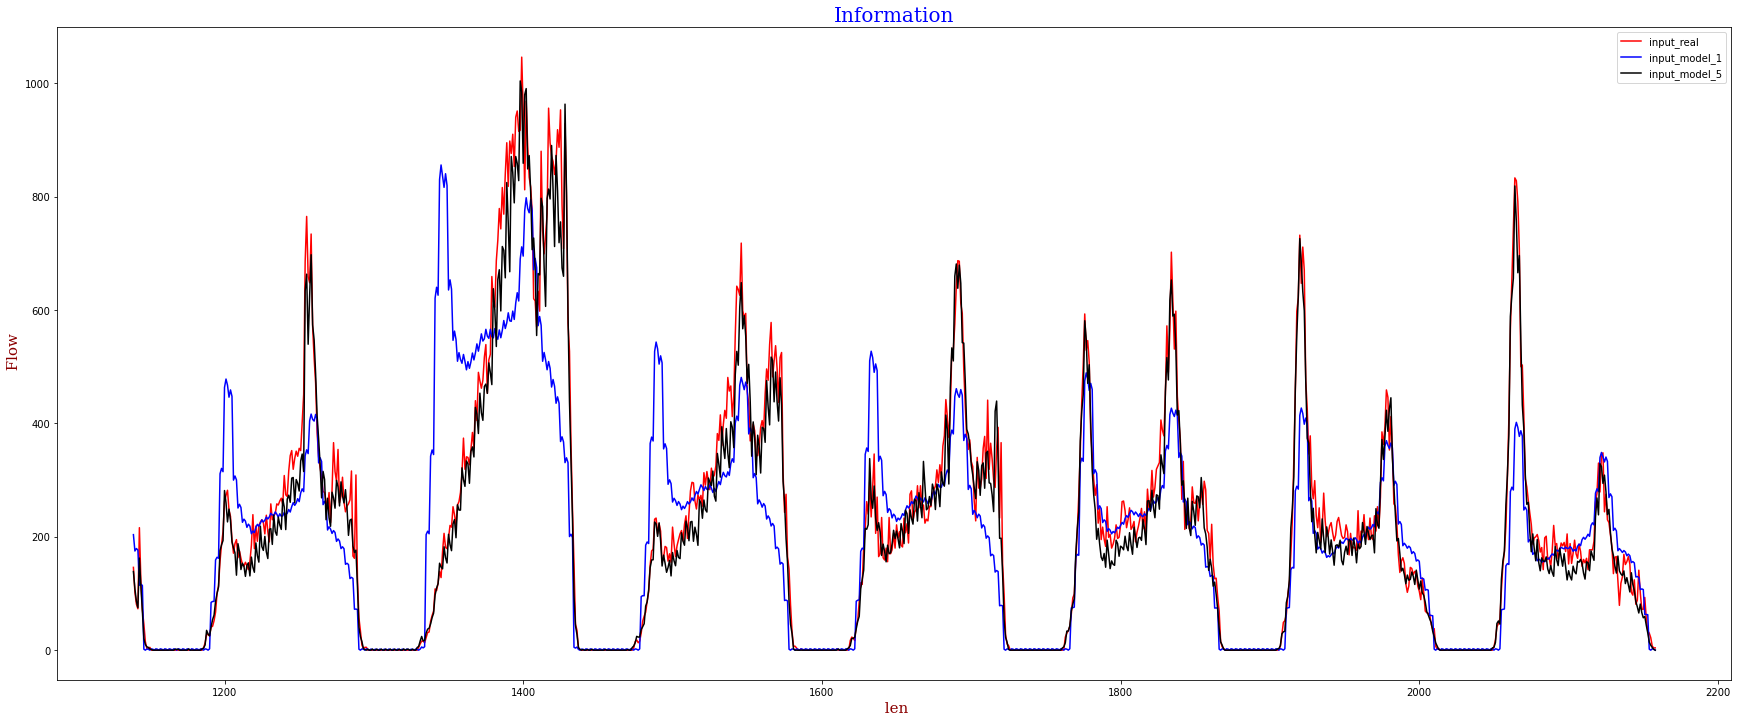

In [14]:
import numpy
from matplotlib import pyplot
import pandas
import matplotlib.pyplot as plt 

data_p = pandas.read_csv('../data/preds/' + 'testA_submit_2019-01-25.csv')
input_file_shape=data_p[1139:2159]#برای یک روز 
plt.figure(figsize=(30,12))

#_______________________________input Flow________________________________________________
pyplot.plot(input_file_shape['input_real'], label='input_real',color='red')
pyplot.plot(input_file_shape['input_model_1'], label='input_model_1',color='blue')
#pyplot.plot(input_file_shape['input_model_2'], label='input_model_2',color='orange')
#pyplot.plot(input_file_shape['input_model_3'], label='input_model_3',color='green')
#pyplot.plot(input_file_shape['input_model_4'], label='input_model_4',color='pink')
pyplot.plot(input_file_shape['input_model_5'], label='input_model_5',color='black')
#_______________________________output Flow________________________________________________ 
#pyplot.plot(input_file_shape['output_model_'], label='output_model_1',color='red')

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
plt.xlabel(" len", fontdict = font2)
plt.ylabel(" Flow", fontdict = font2)
plt.title("Information", fontdict = font1)
plt.legend()
pyplot.show()

# **blendResults**

In [ ]:
import pandas as pd
import datetime

def blendResults(files):
    # weights = [2, 1, 1, 1, 1]
    # weights = [1, 1, 1, 1, 1]
    # weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    weights = [1] * len(files)

    in_preds = 0
    out_preds = 0
    for idx, file in enumerate(files):
        # if not file.endswith('.csv'):
        #     continue
        data = pd.read_csv(DATA_PATH_PRED+file)
        in_preds = in_preds + weights[idx] * data[HEADER_IN]
        out_preds = out_preds + weights[idx] * data[HEADER_OUT]

    in_preds = in_preds / sum(weights)
    out_preds = out_preds / sum(weights)

    submit = pd.read_csv(DATA_PATH_TEST + SUBMIT_FILE)

    submit[HEADER_IN] = in_preds
    submit[HEADER_OUT] = out_preds

    file_name = SUBMIT_RESULT[:-4] + '_' + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + '.csv'

    submit.to_csv(file_name, index=False)


if __name__ == '__main__':
    files = os.listdir(DATA_PATH_PRED)
    blendResults(files)

